# Simulation of a Positron induced Muon Source

Muon colliders are an intriguing proposition for future colliders in the high energy frontier: they would provide cleaner events than hadron colliders and are less subject to bremsstrahlung (and require smaller radius circular colliders in the acceleration) compared to the electrons’ ones.

So studies on the possibilities offered by these colliders, as well as the mechanism needed in order to produce muon beams, are currently studied by the physics community. In fact producing an high luminosity muon beam is not an easy task at all: muons can not simply be extracted like electrons but must be produced by interactions and the production, cooling and acceleration must happen really quickly since muons, unlike their lighter lepton counterparts, decay. One of the studied approaches to produce such a beam is to use electron-positron collisions at centre-of-mass energy just above the $μ^+μ^−$production threshold, which is able to provide muon couples with low transverse momenta.


In this project, divided in 2 parts, we study the final product of the reaction $e^+e^-\toμ^+μ^−$, where $e^-$ is in the laboratory frame in a fixed beryllium target while $e^+$ is accelerated to $[44,50]\,GeV$. In particular we will provide part 2 of this simulation, which starts from the results from part 1 (momentum and position distributions of muons) and studies the optimal configuration to  measure the particles.



# Importing dataset and libraries

In [ ]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from scipy import optimize
from scipy.optimize import brentq
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from numba import guvectorize, vectorize, float64, int64
%matplotlib inline

We were given a dataset containing 1 million events, each characterized by 12 variables:

In [ ]:
#reading the output of part one
dataold = pd.read_csv('drive/MyDrive/dataset.txt',sep=" ", header = None,
                      names=['X','Y','Z','Px_muon','Py_muon','Pz_muon','Px_antimuon','Py_antimuon','Pz_antimuon','Px_e','Py_e','Pz_e'],index_col=False)
dataold.head()

,X,Y,Z,Px_muon,Py_muon,Pz_muon,Px_antimuon,Py_antimuon,Pz_antimuon,Px_e,Py_e,Pz_e
0,0.006700,-0.000174,0.013579,0.026168,0.005782,27.3669,-0.026168,-0.005782,20.2281,0,0,47.5950
1,-0.001808,0.005898,0.000123,0.029397,-0.004837,19.3068,-0.029397,0.004837,30.3273,0,0,49.6341
2,0.001924,-0.004531,0.010167,0.001136,-0.023830,28.3075,-0.001136,0.023830,19.3267,0,0,47.6342
3,0.007570,0.004268,0.008222,-0.002160,-0.011196,17.4952,0.002160,0.011196,30.0357,0,0,47.5309
4,0.004862,-0.005216,0.011934,0.031203,0.005236,21.6927,-0.031203,-0.005236,26.3991,0,0,48.0918


Where the scattering positions are in meters (with the convention that the target start from _Z=0.00 m_ and ends at _Z=0.03 m_ ), while the momenta are in _GeV/c_.

We can notice that in the file given to us, a few events contain unphysical quantities with 0 on all the entries. Those are about 86 events on the  1 million dataset so we are removing such lines with just zeros by asking the momenta of the positron to be bigger than 1 GeV, since all the physical momenta needed to produce the dimuon couple are in the [44,50] GeV interval.

In [ ]:
#Removing unphysical events with just zeros by asking the momenta of the positron to be bigger than 1 GeV
data=dataold[dataold.iloc[:,11]>1] 
data.index = [i for i in range(len(data.index))]
#scattering point
X=np.array(data.iloc[:,0])
Y=np.array(data.iloc[:,1])
Z=np.array(data.iloc[:,2])
#mu-
Px_mu1=np.array(data.iloc[:,3])
Py_mu1=np.array(data.iloc[:,4])
Pz_mu1=np.array(data.iloc[:,5])
#mu+
Px_mu2=np.array(data.iloc[:,6])
Py_mu2=np.array(data.iloc[:,7])
Pz_mu2=np.array(data.iloc[:,8])
#positron
Px_e=np.array(data.iloc[:,9])
Py_e=np.array(data.iloc[:,10])
Pz_e=np.array(data.iloc[:,11])

In practice the incoming beam section is not point-like (the scattering volume has a cilindrical distribution of radius 0.01 meters and 0.03 meters length) and is diverging. While the first effect has  already been implemented in the scattering points distribution in the original dataset the second one is not, hence we are going to provide this correction.

In order to achieve this we boost by a factor of order $p_{e^+}/1000$ each positron in the outward radial direction springing from Z axis. Choosing the direction completely randomly would have generated a convergent beam instead of a divergent one which is what we aim for!
As the momenta conservation laws require, we then boost the muon system with the same boost.

In [ ]:
#boosting the positron and dimuon sistem to take into account incoming beam divergence
me = 0.5109989461e-3
Mmu = 0.1056583745
Ee_old = np.sqrt(Pz_e**2+me**2)

xy_angle = np.arccos(X/np.sqrt(X**2+Y**2))*np.sign(Y)
beta_n = Pz_e/Ee_old*0.001 + Pz_e/Ee_old*0.0001*np.random.rand(len(data))
gamma = 1/np.sqrt(1-beta_n**2)
beta = -np.array([beta_n*np.cos(xy_angle), beta_n*np.sin(xy_angle),np.zeros((len(data)))])
boost= np.array([[gamma, -gamma*beta[0,:], -gamma*beta[1,:], -gamma*beta[2,:]],
                [-gamma*beta[0,:], 1+(gamma-1)*beta[0,:]*beta[0,:]/beta_n**2, (gamma-1)*beta[0,:]*beta[1,:]/beta_n**2, (gamma-1)*beta[0,:]*beta[2,:]/beta_n**2],
                [-gamma*beta[1,:], (gamma-1)*beta[1,:]*beta[0,:]/beta_n**2, 1+(gamma-1)*beta[1,:]*beta[1,:]/beta_n**2, (gamma-1)*beta[1,:]*beta[2,:]/beta_n**2],
                [-gamma*beta[2,:], (gamma-1)*beta[2,:]*beta[0,:]/beta_n**2, (gamma-1)*beta[2,:]*beta[1,:]/beta_n**2, 1+(gamma-1)*beta[2,:]*beta[2,:]/beta_n**2]])
fourM_old_e = np.array([Ee_old, Px_e, Py_e, Pz_e])
fourM_e = np.empty((4,len(data)))
#matrix product
for i in range(4):
    aux = np.zeros(len(data))
    for k in range(4):
        aux+=boost[i,k,:]*fourM_old_e[k,:]
    fourM_e[i,:] = aux

#New boosted positron momenta    
Px_e=fourM_e[1]
Py_e=fourM_e[2]
Pz_e=fourM_e[3]

Emu1_old = np.sqrt(Px_mu1**2+Py_mu1**2+Pz_mu1**2+Mmu**2)
fourM_old_mu1 = np.array([Emu1_old, Px_mu1, Py_mu1, Pz_mu1])
Emu2_old = np.sqrt(Px_mu2**2+Py_mu2**2+Pz_mu2**2+Mmu**2)
fourM_old_mu2 = np.array([Emu2_old, Px_mu2, Py_mu2, Pz_mu2])

#boosting the dimuon system, first the muon
fourM_mu1 = np.empty((4,len(data)))
for i in range(4):
    aux = np.zeros(len(data))
    for k in range(4):
        aux+=boost[i,k,:]*fourM_old_mu1[k,:]
    fourM_mu1[i,:] = aux
Px_mu1 = fourM_mu1[1]
Py_mu1 = fourM_mu1[2]
Pz_mu1 = fourM_mu1[3]
#then boost the antimuon    
fourM_mu2 = np.empty((4,len(data)))
for i in range(4):
    aux = np.zeros(len(data))
    for k in range(4):
        aux+=boost[i,k,:]*fourM_old_mu2[k,:]
    fourM_mu2[i,:] = aux
Px_mu2 = fourM_mu2[1]
Py_mu2 = fourM_mu2[2]
Pz_mu2 = fourM_mu2[3]

#free some memory, we don't need the pandas dataframe anymore, so we move the length in an int to remove the last reference
#and then delete it
NEvents=len(data.index)
del data


# Particle motion


Our first task is to choose where to put our silicon detectors. Since the statistics in the actual experiment is actually very small, it become essential to not lose good events and so to have an acceptance of 100%.

In order to do that we will reconstruct the particle trajectory and plot the particle position at the Z at which we intend to place the detectors: in this way we can study the particles transverse positions distribution and choose how large the detectors need to be, by plotting the proposed shape and checking that all events are inside.

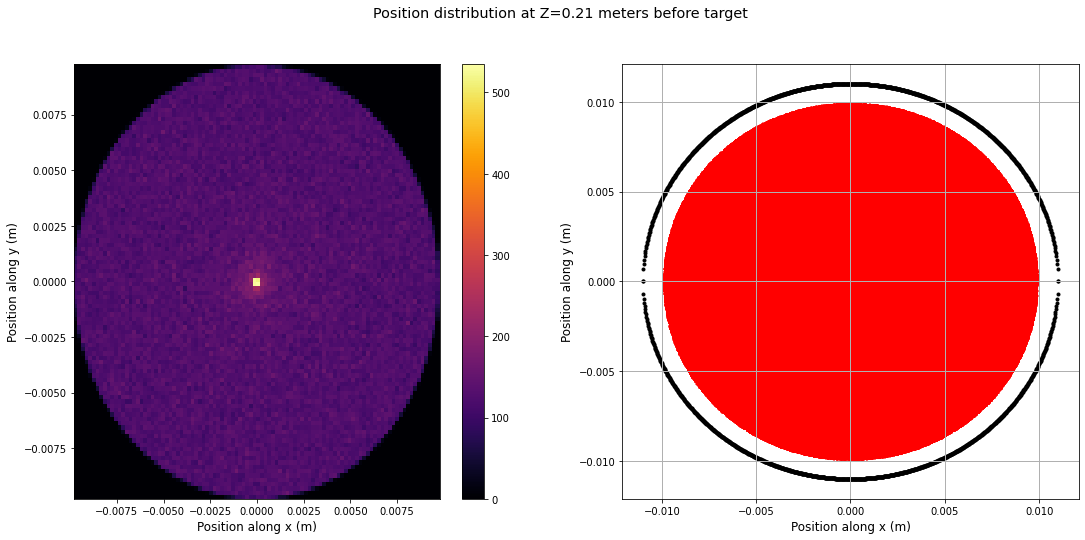

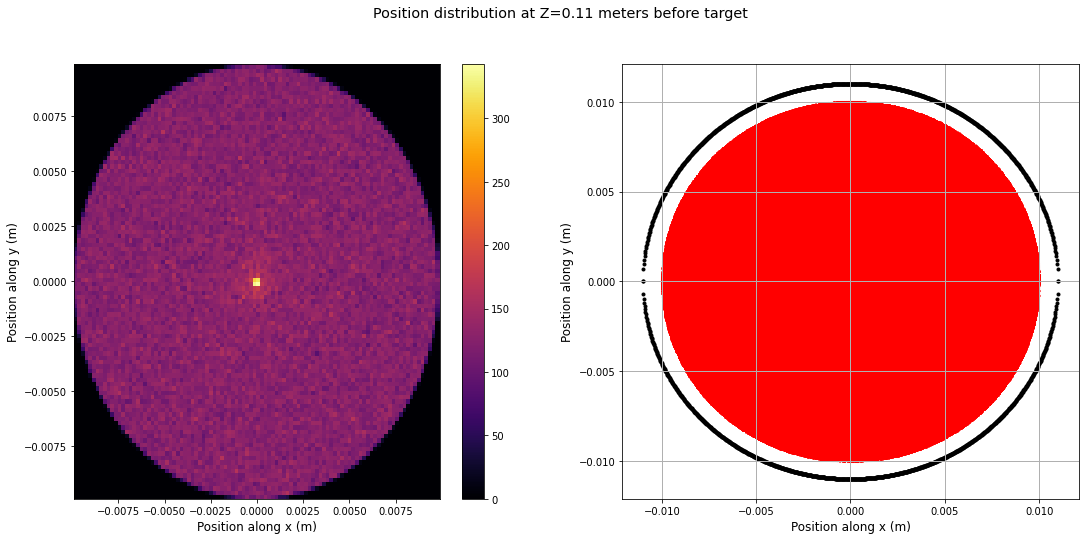

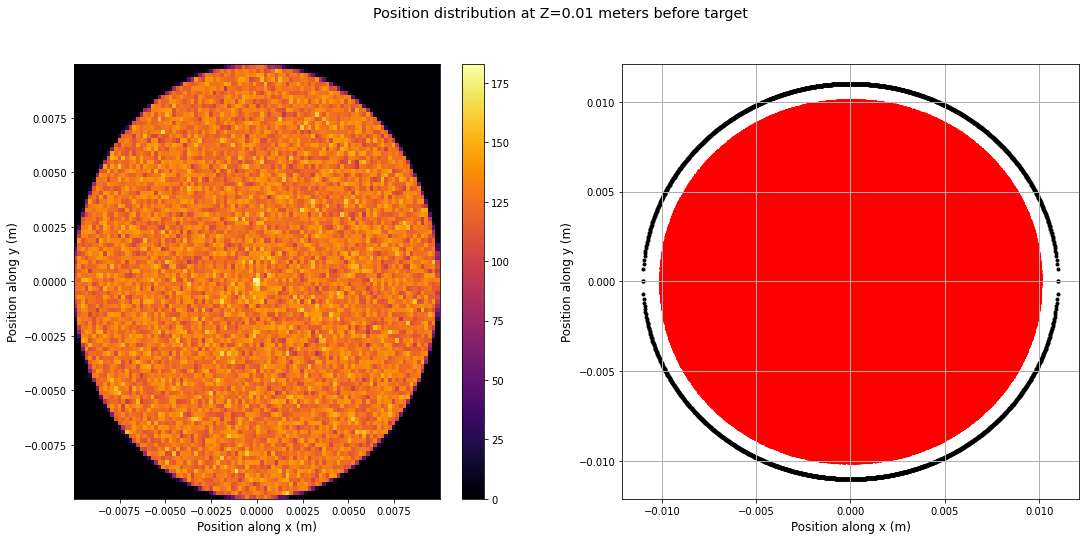

In [ ]:
#Reconstructing the trajectories of positrons
#x(t)=X+px*t
#y(t)=Y+py*t
#z(t)=Z+pz*t
#starting from X,Y,Z of scattering, we'll compute at what t (parametric time) the positron would have been in position z(t) of the detectors
#and then use such t to compute the corresponding x,y, since they are assumed to move in a straight line

Z_Det_beforeTarg=[-0.21,-0.11,-0.01]
for i in Z_Det_beforeTarg:
    t=(i-Z)/Pz_e   #array of "t" parameter, one for each event
    x=X+Px_e*t    #element-wise operations
    y=Y+Py_e*t

    #plot the histogram with the particle distribution
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(18,8))
    fig.suptitle('Position distribution at Z={} meters before target'.format(-1*i),fontsize='x-large')
    h2d = ax1.hist2d(x,y,bins=(100,100),cmap='inferno')
    ax1.set_xlabel("Position along x (m)",fontsize='large')
    ax1.set_ylabel("Position along y (m)",fontsize='large')
    fig.colorbar(h2d[3], ax=ax1)
    
    #distribution with the detector shape
    ax2.scatter(x,y,color='red', marker='x')
    r=0.011#radius
    xs=np.linspace(-r,r,1000)
    ax2.scatter(xs,np.sqrt(r**2-xs**2),color='black',marker='.')
    ax2.scatter(xs,-np.sqrt(r**2-xs**2),color='black',marker='.')
    ax2.grid(b=True,which='both', linewidth=1)
    ax2.set_xlabel("Position along x (m)",fontsize='large')
    ax2.set_ylabel("Position along y (m)",fontsize='large')
    plt.show()


As seen in the histogram, just before target the scattering points have a uniform distribution over beam section radius. Going at more negative Z (i.e. further away from target in the source direction) we see that our boost indeed works as if the beam started very focused and reached a section of r=0.011 m, near target, almost flat distributed.


The very same study is done for the muons. For the 2nd generation leptons there is another feature we want to study other than the position distribution of all events: how close are the muon and antimuon of the same event?
In order to reconstruct the trajectory efficiently, we want the muons to be in different pixels for as many detector as possible, so that we can have a more correct reconstruction of their direction before the magnet. This is the so called "study of smearing": we will plot how many muon couples are closer than $r= \text{pixel size} \cdot \sqrt(2)$ when reaching a detector and so how many could actually give signal in the same pixel. We will plot them in a histogram and check that such events are a very small minority.



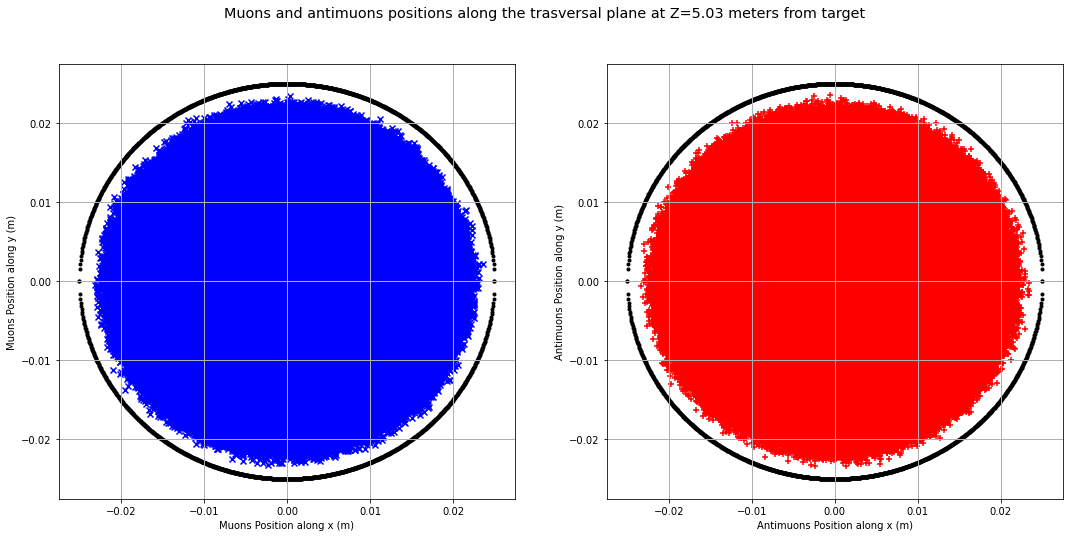

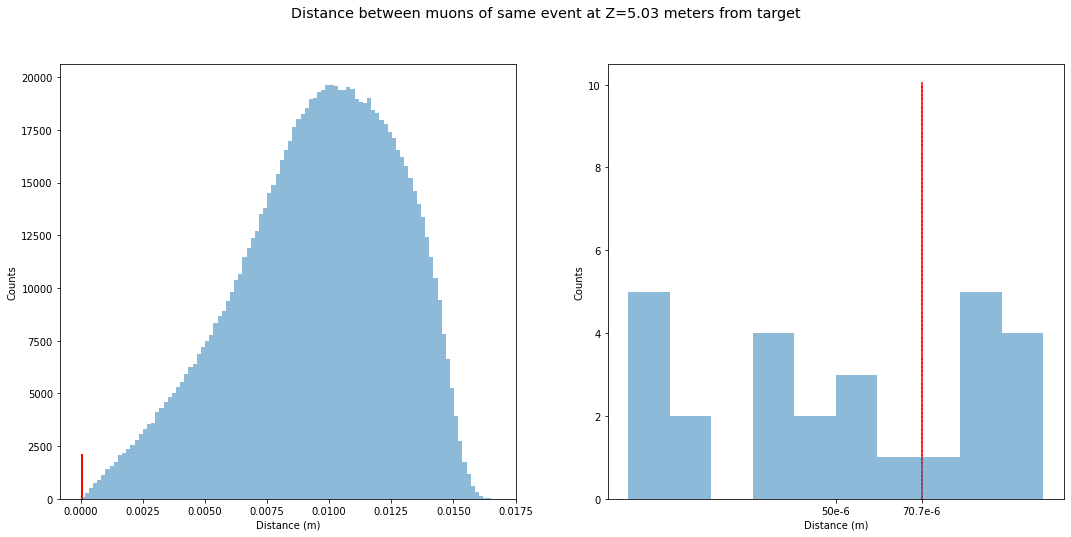

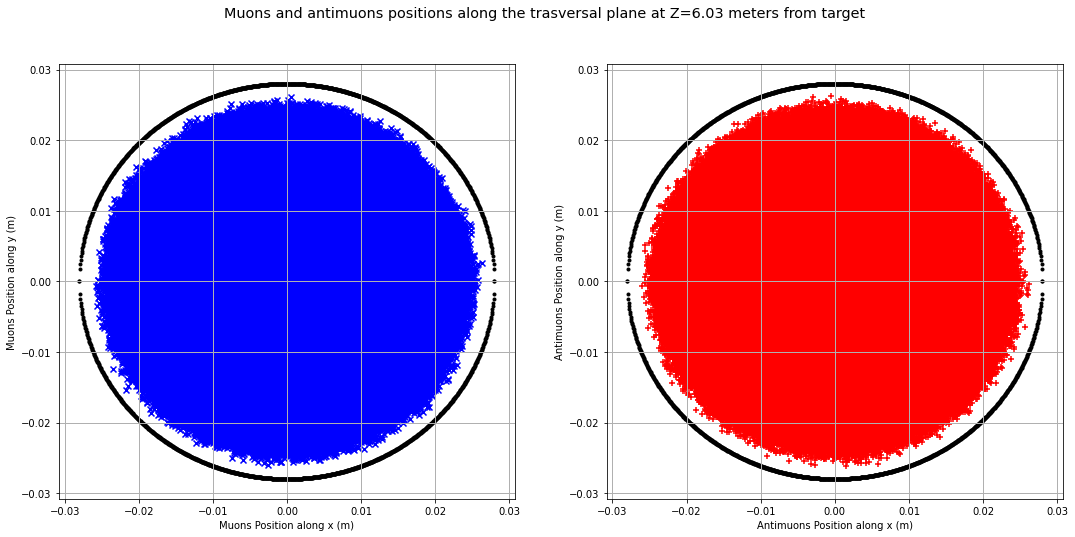

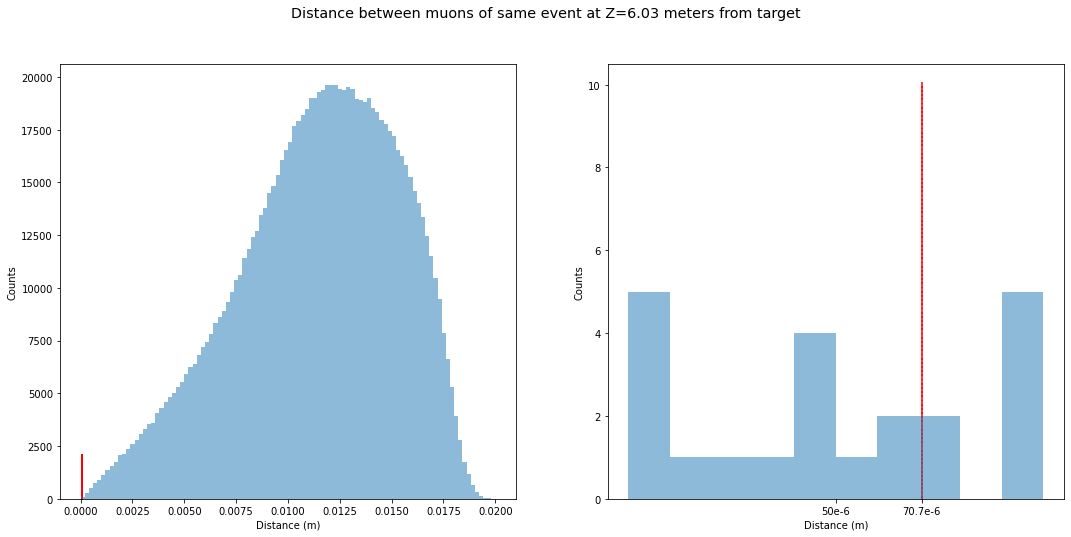

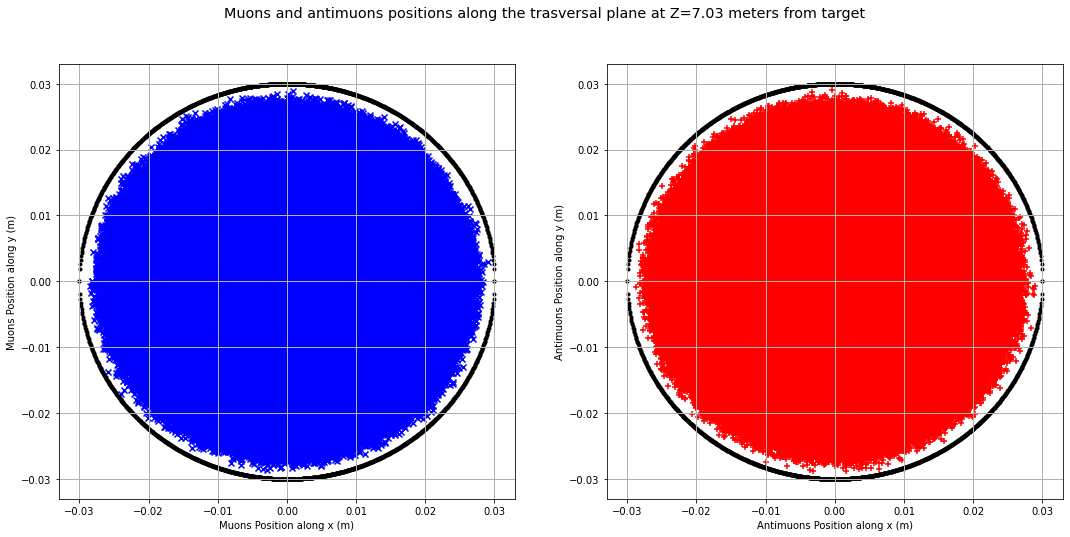

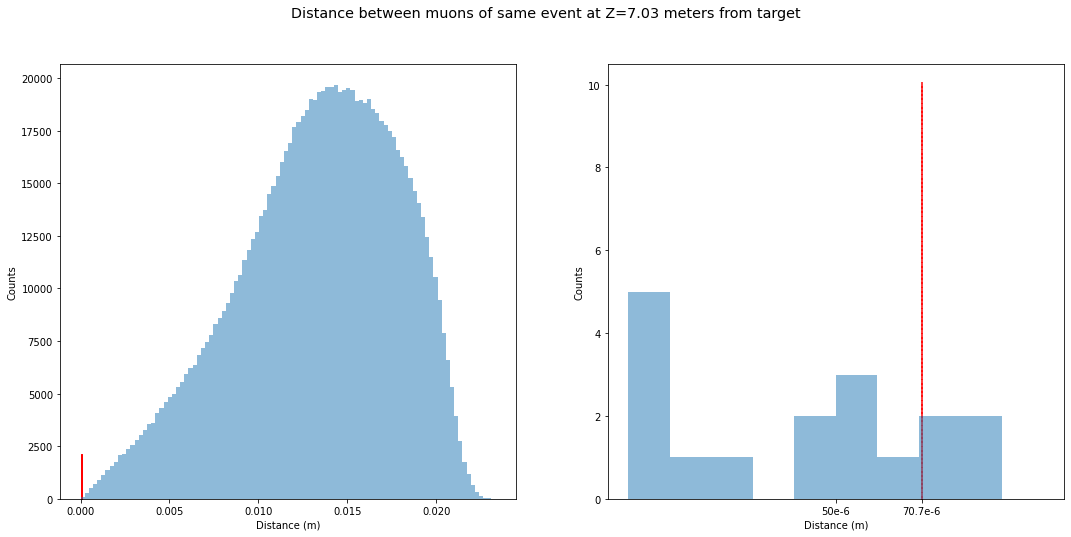

In [ ]:
#trajectories of muons until magnet
#x(t)=X+px*t
#y(t)=Y+py*t
#z(t)=Z+pz*t
#starting from X,Y,Z of scattering, I'll compute at what t the muons would have been in position z(t)
#and then use such t to compute the corresponding x,y

B=1.7 #Tesla
L=2 #lenght in meters of the magnet, assumed large enough to avoid particles exiting laterally and boundary effects
Zstartmagn=7.23
massmuon=0.10566 #Gev

#auxiliary arrays for particle entering point in the magnet
Xtempminus=np.empty((NEvents))
Ytempminus=np.empty((NEvents))
Xtempplus=np.empty((NEvents))
Ytempplus=np.empty((NEvents))

#detector positions (+ start of the magnet)
Z_Det_beforeMagn=[5.03,6.03,7.03,Zstartmagn]
#detectors radius
Radiuses=[0.025,0.028,0.03,0]

for i,r in zip(Z_Det_beforeMagn,Radiuses):
    tn=(i-Z)/Pz_mu1   #array of"t" parameter,one for each event
    xn=X+Px_mu1*tn    #element-wise operations
    yn=Y+Py_mu1*tn
    tp=(i-Z)/Pz_mu2
    xp=X+Px_mu2*tp
    yp=Y+Py_mu2*tp
    
    if(i==Zstartmagn):
        Xtempminus=xn
        Ytempminus=yn
        Xtempplus=xp
        Ytempplus=yp
        break

    #negative muons
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(18,8))
    fig.suptitle('Muons and antimuons positions along the trasversal plane at Z={} meters from target'.format(i),fontsize='x-large')
    ax1.grid(b=True,which='both', linewidth=1)
    #particle positions
    ax1.scatter(xn,yn,color='blue',marker='x')
    #detector boundaries
    xs=np.linspace(-r,r,1000)
    ax1.scatter(xs,np.sqrt(r**2-xs**2),color='black',marker='.')
    ax1.scatter(xs,-np.sqrt(r**2-xs**2),color='black',marker='.')
    ax1.set_xlabel("Muons Position along x (m)")
    ax1.set_ylabel("Muons Position along y (m)")
    
    
    
    #positive muons
    ax2.grid(b=True,which='both', linewidth=1)
    #particle positions
    ax2.scatter(xp,yp,color='red',marker='+')
    #detector boundaries
    xs=np.linspace(-r,+r,1000)
    ax2.scatter(xs,np.sqrt(r**2-xs**2),color='black',marker='.')
    ax2.scatter(xs,-np.sqrt(r**2-xs**2),color='black',marker='.')
    ax2.set_xlabel("Antimuons Position along x (m)")
    ax2.set_ylabel("Antimuons Position along y (m)")
    plt.show()

    
    #study of smearing (i.e. how close are the mu+ and mu- of same event)
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(18,8))
    fig.suptitle('Distance between muons of same event at Z={} meters from target'.format(i),fontsize='x-large')
    ax1.hist(np.sqrt((xp-xn)**2+(yp-yn)**2),bins=100,alpha = 0.5, lw=3)
    ax1.set_xlabel("Distance (m)")
    ax1.set_ylabel("Counts")
    plt.xticks([50e-6,0.005,0.01,0.015,0.02],['50e-6','0.005','0.01','0.015','0.02'])
    ax1.scatter(np.full((100),np.sqrt(2)*50e-6,dtype='float'),np.linspace(0,2000,100,dtype='float'),color='red',marker='|')

    #zooming in the intersting part
    ax2.hist(np.sqrt((xp-xn)**2+(yp-yn)**2),range=[0,0.0001],alpha = 0.5, lw=3)
    ax2.set_xlabel("Distance (m)")
    ax2.set_ylabel("Counts")
    plt.xticks([50e-6,70.7e-6],['50e-6','70.7e-6'])
    ax2.scatter(np.full((100),np.sqrt(2)*50e-6,dtype='float'),np.linspace(0,10,100,dtype='float'),color='red',marker='|')
    plt.show()
    

We can indeed see that only a really small fraction of the events may have both muons in the same pixel.

This is not the only reason we chose to place the detectors further away from the target and close to the magnet: since trajectories will be reconstructed with an error, the further away the magnet is from the detectors, the more important the error on the angle of the reconstructed trajectory will become, since the error of the entry point of the particle in the magnet is directly proportional to it.

Let's now compute the trajectories of the particles in the magnetic field.
A geometric approach as been used for this part. First we computed the radius of the circular trajectory:

**R**[meters]= **Ptransverse**[Gev/c]/(**B**[T] * **0.3**)

Then we exploited the fact that the transversal momentum is always perpendicular to the circular trajectory. We built the circonference equation with such radius whose center lies in the perpendicular direction of the incoming momentum. Then we find the intersection between the circonference equation and the Z corresponding to the end of the magnet. Finally the momentum is found by requiring its modulus to be equal to the incoming one and have direction perpendicular to the radial direction of the ending point.

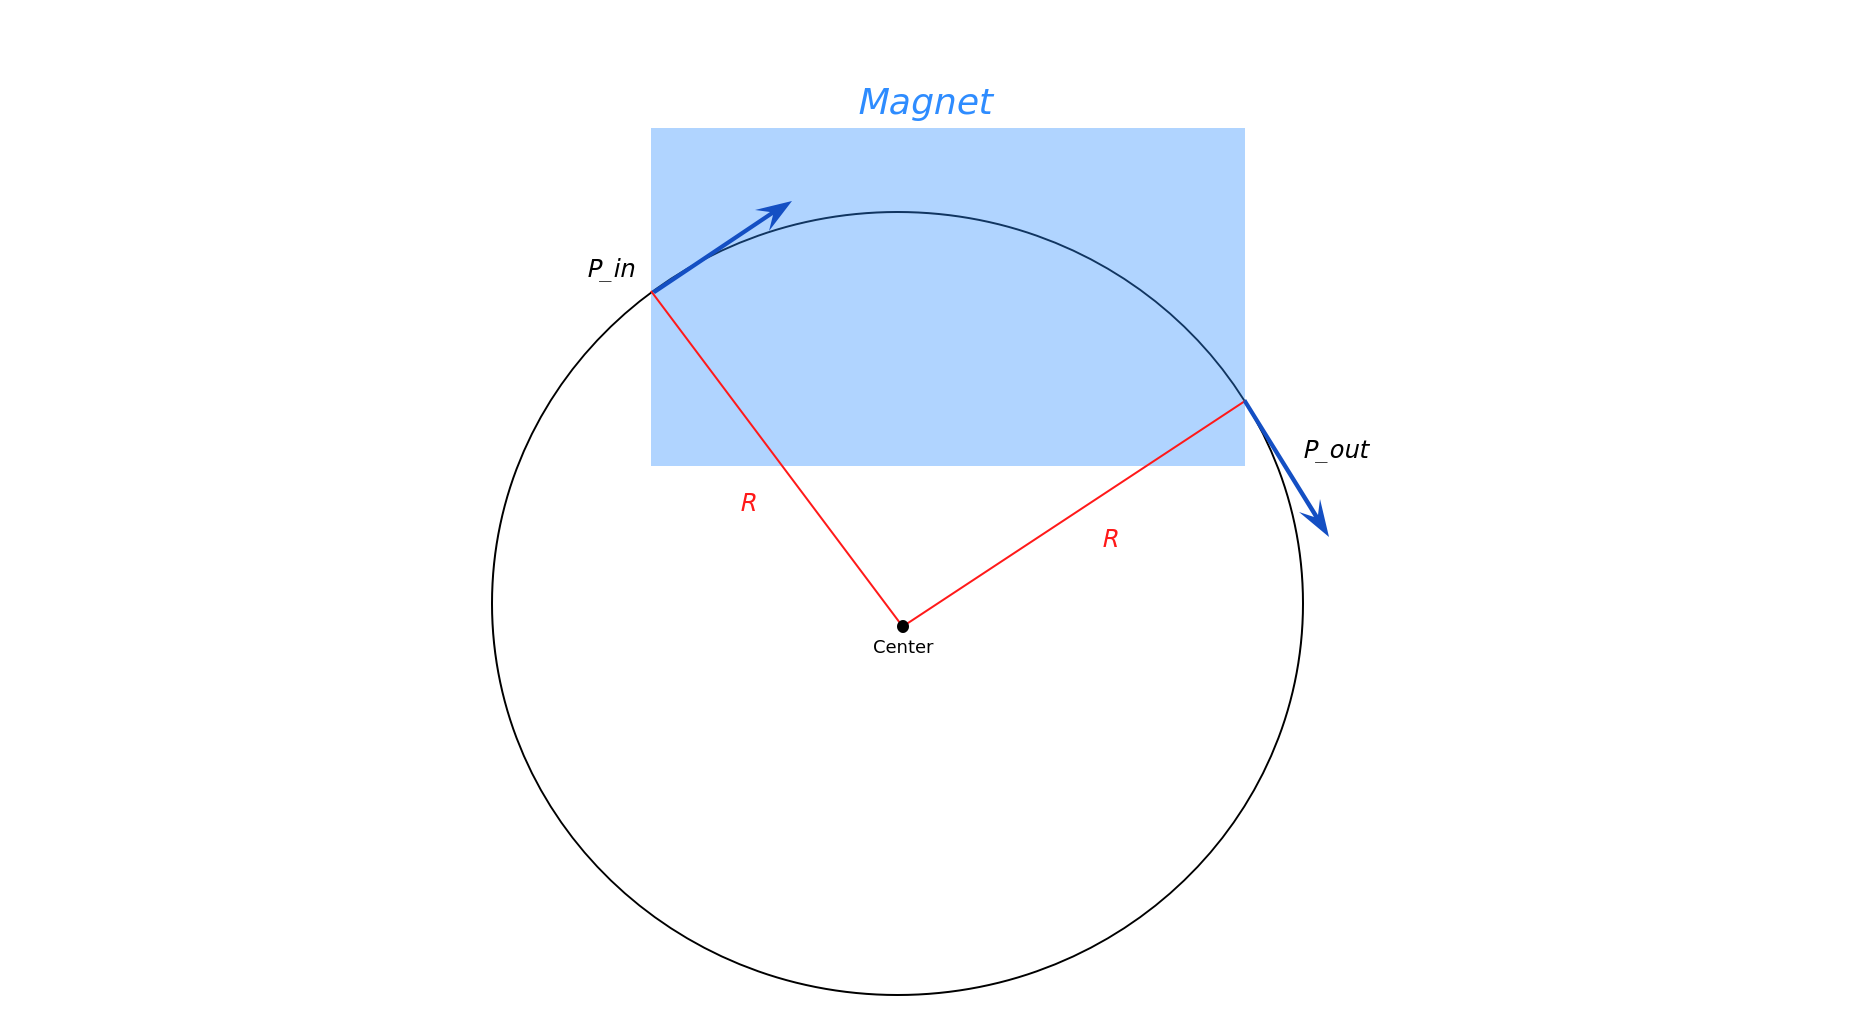

In [ ]:
from IPython.display import Image
Image("drive/MyDrive/circular_trajectory.png")

In [ ]:
#find center of circle
R_pos=np.sqrt(Pz_mu2**2+Px_mu2**2)/B/0.3 #meters
R_neg=np.sqrt(Pz_mu1**2+Px_mu1**2)/B/0.3

#positions and momenta after magnet
Pos_muneg=np.empty((NEvents,3))
Momenta_muneg=np.empty((NEvents,2))

Pos_mupos=np.empty((NEvents,3))
Momenta_mupos=np.empty((NEvents,2))

#Moduli of tranverse momenta
P_neg=np.sqrt(Px_mu1**2+Pz_mu1**2)
P_pos=np.sqrt(Px_mu2**2+Pz_mu2**2)

#auxiliary arrays
radial_versor=np.empty((NEvents,3))
Circ_center=np.empty((NEvents,2))
theta=np.empty((NEvents))

#mu-
#find center of arc of circumference 
direction = np.array([Pz_mu1*B, np.zeros(NEvents), -Px_mu1*B]).T  #manually writing the cross product
radial_versor[:,0] = direction[:,0]/np.sqrt(direction[:,0]**2+direction[:,2]**2)
radial_versor[:,1] = direction[:,1]/np.sqrt(direction[:,0]**2+direction[:,2]**2)
radial_versor[:,2] = direction[:,2]/np.sqrt(direction[:,0]**2+direction[:,2]**2)
Circ_center[:,0] = Xtempminus+R_neg*radial_versor[:,0]
Circ_center[:,1] = np.full((NEvents), Zstartmagn)+R_neg*radial_versor[:,2]

#use E.O.M.
#(x-xc)^2+(z-zc)^2=R^2, I invert it and impose Z=end of magnet: I get two x's as solutions:solution - with mu-
#solution + with mu + (from geometry)   
Pos_muneg[:,0]=Circ_center[:,0]-np.sqrt(R_neg**2-((Zstartmagn+L)-Circ_center[:,1])**2)
Pos_muneg[:,2]=np.full((NEvents),Zstartmagn+L)

#by using ortogonality (P is always ortogonal to circunference) get Px,Pz after rotation
final_radialdirection=np.array([Pos_muneg[:,0]-Circ_center[:,0],
                                np.full((NEvents),0),
                                Pos_muneg[:,2]-Circ_center[:,1]]).T

finalvector = np.array([final_radialdirection[:,2]*B, np.zeros(NEvents), -final_radialdirection[:,0]*B]).T
finalversor = np.empty((NEvents,3))
finalversor[:,0] = finalvector[:,0]/np.sqrt(finalvector[:,0]**2+finalvector[:,2]**2)
finalversor[:,1] = finalvector[:,1]/np.sqrt(finalvector[:,0]**2+finalvector[:,2]**2)
finalversor[:,2] = finalvector[:,2]/np.sqrt(finalvector[:,0]**2+finalvector[:,2]**2)
Momenta_muneg[:,0] = P_neg*finalversor[:,0]
Momenta_muneg[:,1] = P_neg*finalversor[:,2]
theta=np.arccos(-(radial_versor[:,0]*final_radialdirection[:,0]+
                  radial_versor[:,1]*final_radialdirection[:,1]+
                  radial_versor[:,2]*final_radialdirection[:,2])/
                np.sqrt(final_radialdirection[:,0]**2+final_radialdirection[:,2]**2))

#"time parameter"=space(=R*theta)/transverse_momenta                      
k=R_neg*theta/P_neg
#E.O.M. y(k)=Y+py*k
Pos_muneg[:,1]=Ytempminus+Py_mu1*k


#mu+
#find center of arc of circunference 
direction = np.array([-Pz_mu2*B, np.zeros(NEvents), Px_mu2*B]).T  #manually writing the cross product
radial_versor[:,0] = direction[:,0]/np.sqrt(direction[:,0]**2+direction[:,2]**2)
radial_versor[:,1] = direction[:,1]/np.sqrt(direction[:,0]**2+direction[:,2]**2)
radial_versor[:,2] = direction[:,2]/np.sqrt(direction[:,0]**2+direction[:,2]**2)
Circ_center[:,0] = Xtempplus+R_pos*radial_versor[:,0]
Circ_center[:,1] = np.full((NEvents), Zstartmagn)+R_pos*radial_versor[:,2]

#use E.O.M.
#(x-xc)^2+(z-zc)^2=R^2, I invert it and impose Z=end of magnet: I get two x's as solutions:solution - with mu-
#solution + with mu + (from geometry)
Pos_mupos[:,0]=Circ_center[:,0]+np.sqrt(R_pos**2-((Zstartmagn+L)-Circ_center[:,1])**2)
Pos_mupos[:,2]=np.full((NEvents),Zstartmagn+L)

#by using ortogonality (P is always ortogonal to circunference) get Px,Pz after rotation
final_radialdirection=np.array([Pos_mupos[:,0]-Circ_center[:,0],
                                np.full((NEvents),0),
                                Pos_mupos[:,2]-Circ_center[:,1]]).T
                       
finalvector = np.array([-final_radialdirection[:,2]*B, np.zeros(NEvents), final_radialdirection[:,0]*B]).T
finalversor[:,0] = finalvector[:,0]/np.sqrt(finalvector[:,0]**2+finalvector[:,2]**2)
finalversor[:,1] = finalvector[:,1]/np.sqrt(finalvector[:,0]**2+finalvector[:,2]**2)
finalversor[:,2] = finalvector[:,2]/np.sqrt(finalvector[:,0]**2+finalvector[:,2]**2)
Momenta_mupos[:,0] = P_pos*finalversor[:,0]
Momenta_mupos[:,1] = P_pos*finalversor[:,2]
theta=np.arccos(-(radial_versor[:,0]*final_radialdirection[:,0]+
                  radial_versor[:,1]*final_radialdirection[:,1]+
                  radial_versor[:,2]*final_radialdirection[:,2])/
                np.sqrt(final_radialdirection[:,0]**2+final_radialdirection[:,2]**2))

#"time parameter"=space(=R*theta)/transverse_momenta
k=R_pos*theta/P_pos
#E.O.M. y(k)=Y+py*k
Pos_mupos[:,1]=Ytempplus+Py_mu2*k

Now we can use the free motion equation from the exit position and momenta of the particles.

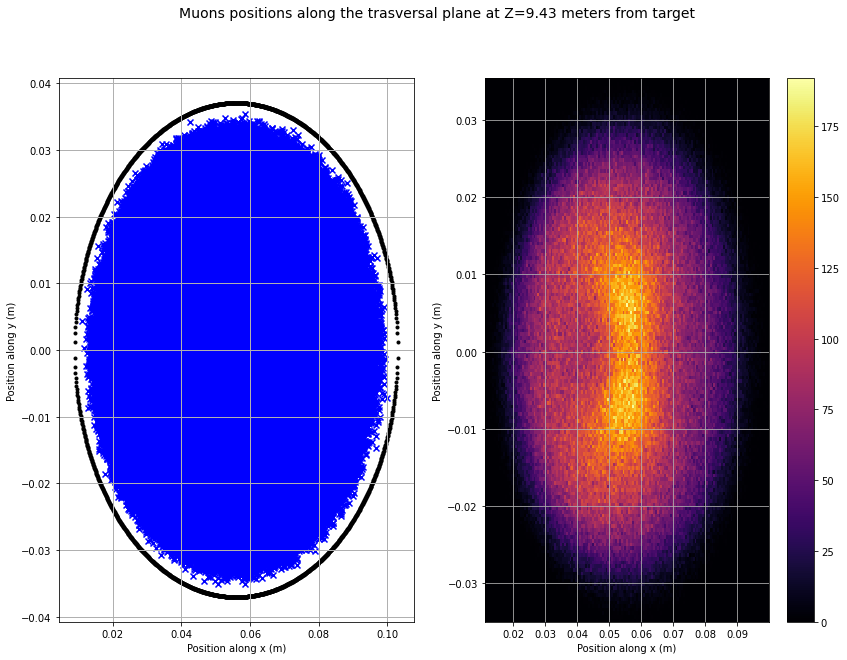

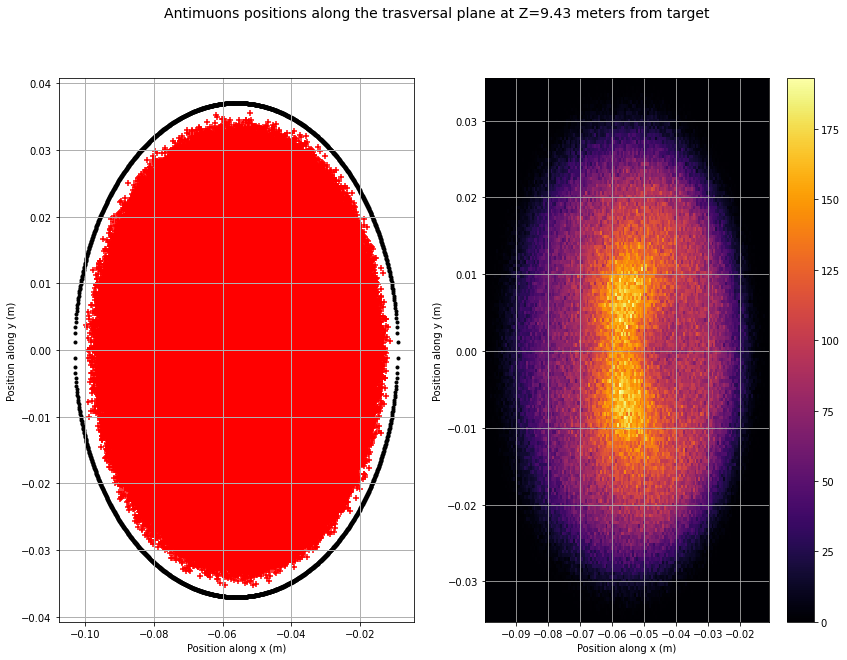

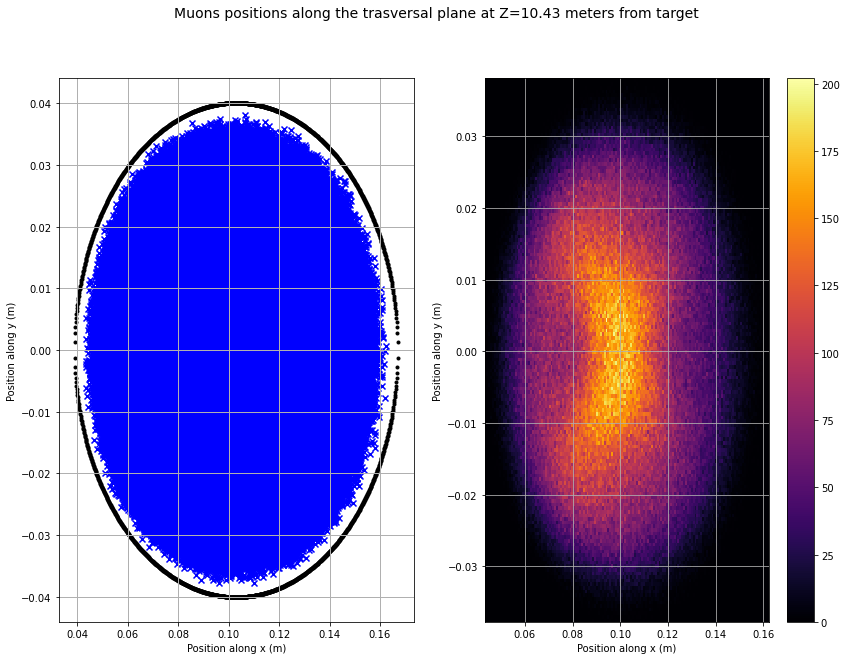

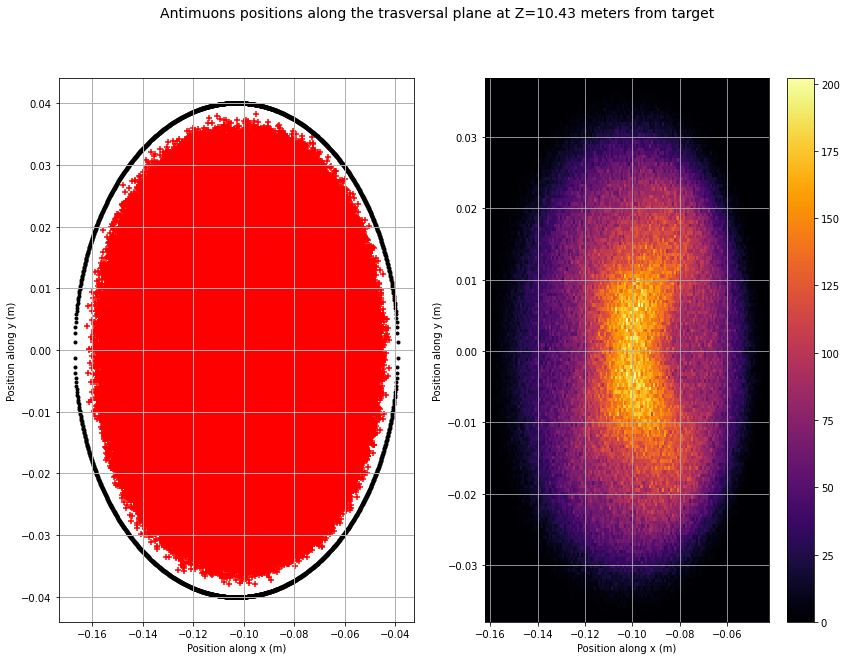

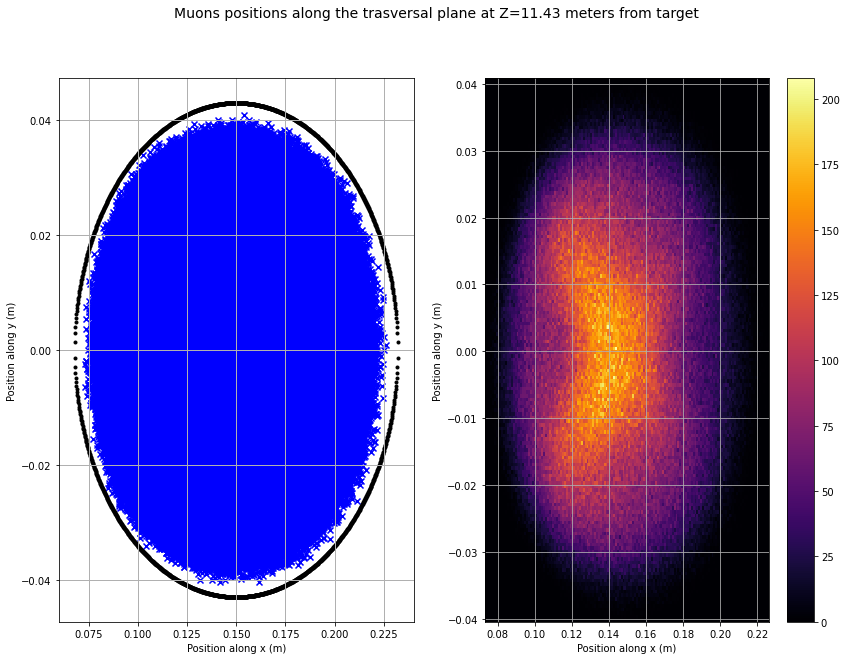

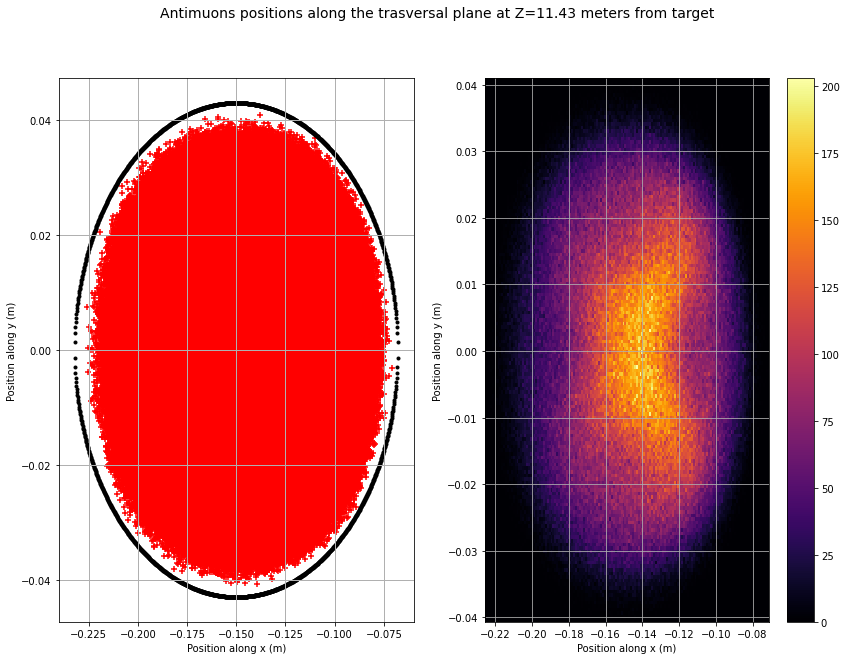

In [ ]:
##solve same equations as before to get where they hit final detectors after magnet
Z_Det_afterMagn=[9.43, 10.43, 11.43] 
#parameters of detector shape, used  to check if detector's sizes are accurate
x_center=[0.056,0.103,0.15]
a=[0.047,0.064,0.082] #x semiaxis
b=[0.037,0.04,0.043] #y semiaxis

for i,xi,ai,bi in zip(Z_Det_afterMagn,x_center,a,b):
    #negative muons
    tn=(i-Pos_muneg[:,2])/Momenta_muneg[:,1]   #array of"t" parameter,one for each event
    xn=Pos_muneg[:,0]+Momenta_muneg[:,0]*tn    #element-wise operations
    yn=Pos_muneg[:,1]+Py_mu1*tn
    
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,10))
    fig.suptitle('Muons positions along the trasversal plane at Z={} meters from target'.format(i), fontsize=14)
    ax1.scatter(xn,yn,color='blue',marker='x')
    ax1.set_xlabel("Position along x (m)")
    ax1.set_ylabel("Position along y (m)")
    #draw the detector shape
    xs=np.linspace(xi-ai,xi+ai,1000)
    ax1.scatter(xs,bi*np.sqrt(1.001-(xs-xi)**2/ai**2),color='black',marker='.')
    ax1.scatter(xs,-bi*np.sqrt(1.001-(xs-xi)**2/ai**2),color='black',marker='.')
    ax1.grid(b=True,which='both', linewidth=1)
    h2d = ax2.hist2d(xn,yn,bins=(150,150),cmap='inferno')
    fig.colorbar(h2d[3], ax=ax2)
    plt.grid()
    ax2.set_xlabel("Position along x (m)")
    ax2.set_ylabel("Position along y (m)")
    plt.show()


    #positive muons
    tp=(i-Pos_mupos[:,2])/Momenta_mupos[:,1] 
    xp=Pos_mupos[:,0]+Momenta_mupos[:,0]*tp
    yp=Pos_mupos[:,1]+Py_mu2*tp
    
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,10))
    fig.suptitle('Antimuons positions along the trasversal plane at Z={} meters from target'.format(i),fontsize=14)
    ax1.scatter(xp,yp,color='red',marker='+')
    ax1.grid(b=True,which='both', linewidth=1)
    ax1.set_xlabel("Position along x (m)")
    ax1.set_ylabel("Position along y (m)")
    #draw the detector shape
    xs=np.linspace(-xi-ai,-xi+ai,1000)
    ax1.scatter(xs,bi*np.sqrt(1.001-(xs+xi)**2/ai**2),color='black',marker='.')
    ax1.scatter(xs,-bi*np.sqrt(1.001-(xs+xi)**2/ai**2),color='black',marker='.')
    h2d = ax2.hist2d(xp,yp,bins=(150,150),cmap='inferno')
    fig.colorbar(h2d[3], ax=ax2)
    plt.grid()
    ax2.set_xlabel("Position along x (m)")
    ax2.set_ylabel("Position along y (m)")
    plt.show()



Having visualized the transverse distribution of the particles, we can define the shapes of the detectors. Let's define the coordinate system: the beam center corresponds to (0,0), where y is direction parallel and with same verse of B in the magnet and x is the perpendicular direction (positive verse where muon are deflected).
#### So the detector shapes would be:

+ **Before the target**: we can use circular detectors centered in (0,0) with _radius=0.011 m_, placed as close as possible to the target (Z=-0.21 m; -0.11 m; -0.01 m)

+ **Between target and magnet**: Still the circular shape is mantained, but since the beam is diverging, so is the radius too. We want to have as less smearing as possible and to have a good resolution on the entry point in the magnet, so they will be placed close to the start of the magnet (Z=7.23 m). Keeping in mind these considerations, we choose to place them:
  - at Z=5.03 with r=0.025 m
  - at Z=6.03 with r=0.028 m
  - at Z=7.03 with r=0.03 m
+ **After the target and the magnet**: the circular symmetry is broken and muon and antimuon beams are diffused in different detectors. Each detector is now elliptical and displaced from the (0,0) point. So, by choosing $x_0$,$y_0$ as the center of the ellipse and a,b as the semiaxis for x and y respectively, we have for the muons:
  - Z= 9.43 m with center (0.056 m, 0.000 m) and semiaxis (0.047 m, 0.037 m)
  - Z= 10.43 m with center (0.103 m, 0.000 m) and semiaxis (0.064 m, 0.040 m)
  - Z= 11.43 m with center (0.15 m, 0.000 m) and semiaxis (0.082 m, 0.043 m)

  While, symmetrically, for the antimuons:
  
  - Z= 9.43 m with center (-0.056 m, 0.000 m) and semiaxis (0.047 m, 0.037 m)
  - Z= 10.43 m with center (-0.103 m, 0.000 m) and semiaxis (0.064 m, 0.040 m)
  - Z= 11.43 m with center (-0.150 m, 0.000 m) and semiaxis (0.082 m, 0.043 m)


We chose to use all pixels of pitch$= 50  \mu m$ in order to have the best available resolution for tracking. This costly choice is somewhat compensated by the small number of detectors we employed, as well as the minimization of their transverse dimensions provided by the results of this simulation.

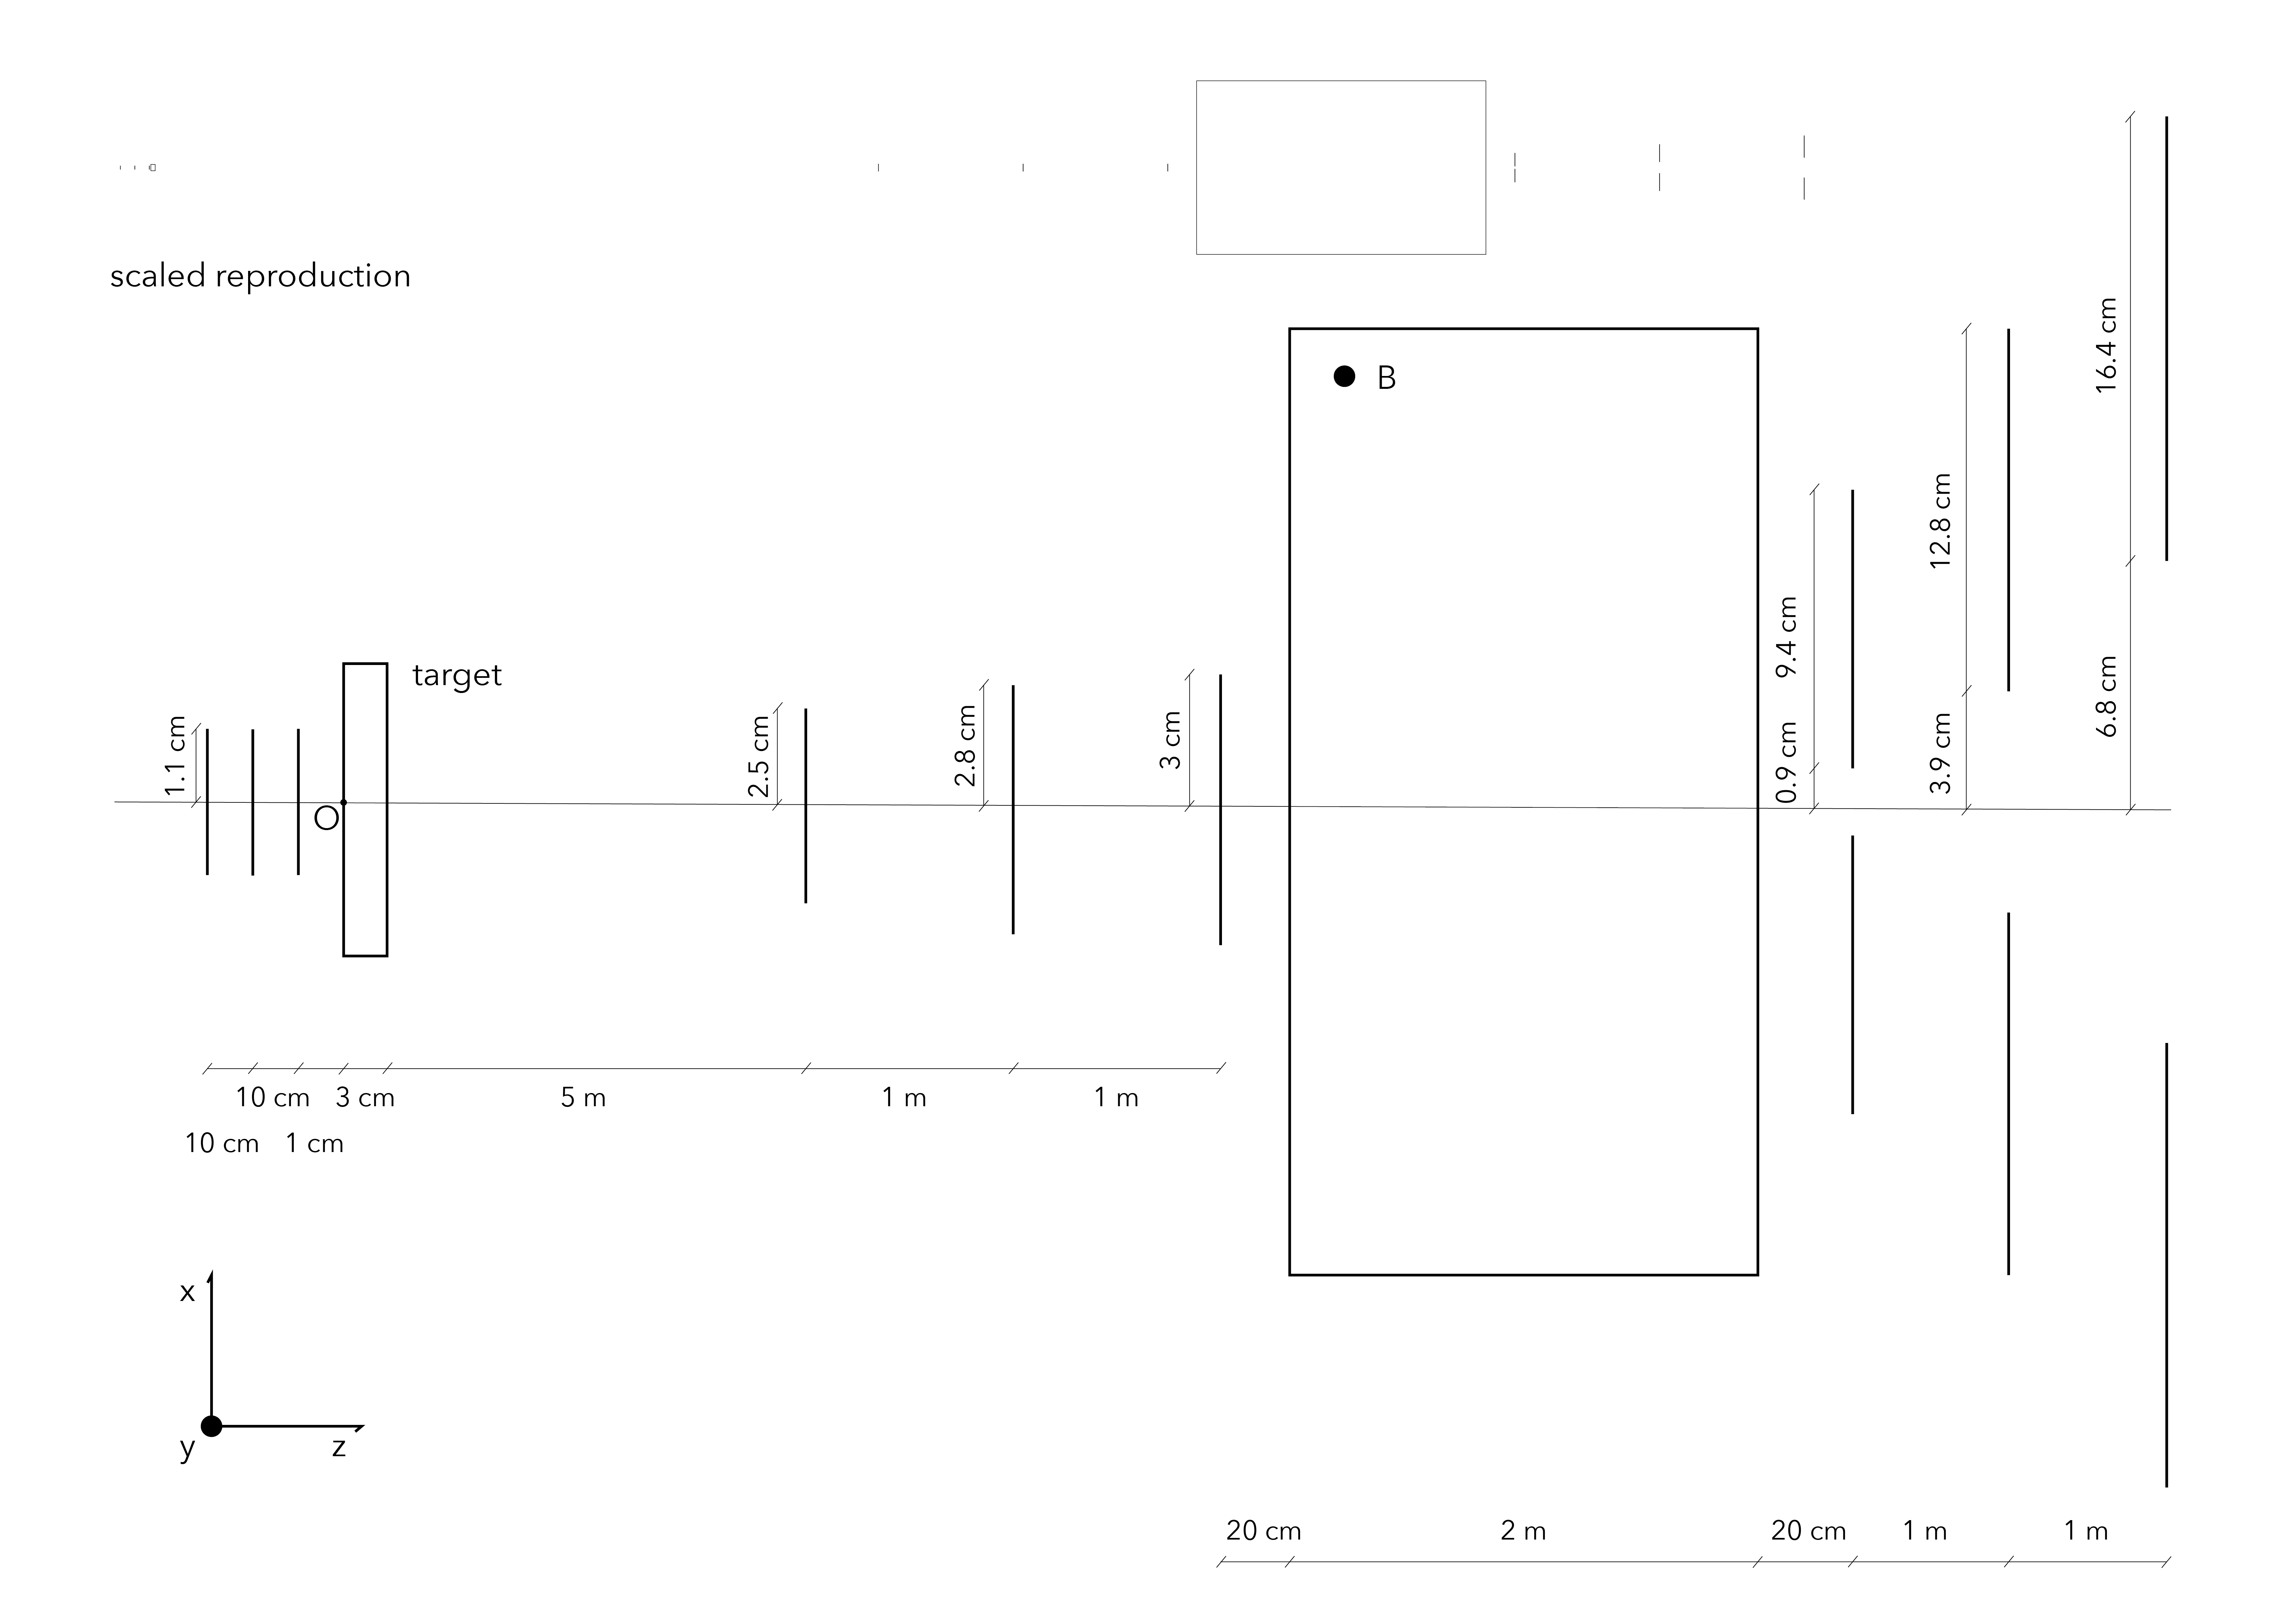

In [ ]:
Image("drive/MyDrive/setup_complete.png")

# Detector creation

In [ ]:
class Pixel:
    def __init__(self, side):
        self.value=0
        self.side=side
    def activate(self):
        self.value=1
        return 1
    def clear(self):
        self.value=0
    def set_center(self,xpos,ypos):
        self.X_center=xpos
        self.Y_center=ypos
        
class Detector:
    def __init__(self,X,Y,sideX,sideY,pitch):
        self.X0 = X
        self.Y0 = Y
        self.sideX = sideX
        self.sideY = sideY
        self.pitch = pitch
        self.pixels = []
    
    def find(self,xpart,ypart):   #activates the pixel in the specified position
        if xpart>self.X0 and ypart>self.Y0 and xpart<(self.X0+self.sideX) and ypart<(self.Y0+self.sideY) :
            a = Pixel(self.pitch)
            a.activate()
            a.set_center(self.X0+int(abs(xpart-self.X0)/self.pitch)*self.pitch+0.5*self.pitch,
                         self.Y0+int(abs(ypart-self.Y0)/self.pitch)*self.pitch+0.5*self.pitch)
            self.pixels.append(a)
        else:
            a = Pixel(self.pitch)
            a.activate()
            a.set_center(self.X0+int(abs(xpart-self.X0)/self.pitch)*self.pitch+0.5*self.pitch,
                         self.Y0+int(abs(ypart-self.Y0)/self.pitch)*self.pitch+0.5*self.pitch)
            self.pixels.append(a)
            print("particle out of detector")
      
    def actives(self): #returns the coordinates of active pixels
        l=[]
        for i in self.pixels:
            l.append([i.X_center, i.Y_center])
        return l

    def clear_all(self):
        for i in self.pixels: 
            i.clear()
      
    def noise(self):
        #extract how many noisy channels
        number=poisson.rvs(mu=1,size=1)
        #choose randomly where to add noise
        temp1=np.random.randint(1,int(self.sideY/self.pitch),number[0])
        temp2=np.random.randint(1,int(self.sideX/self.pitch),number[0])
        for i in range(0,len(temp1)):
            self.find(self.X0+temp2[i]*self.pitch-0.5*self.pitch,self.Y0+temp1[i]*self.pitch-0.5*self.pitch)




While initially we tried to create the detector geometrically (create all pixels and reshape them in the correct form, activate them and clearing them when needed), in the end we opted for the above code, less geometrically appealing but much more memory efficient. In fact in these way only the pixels needed for each event are created, while still performing the check to make sure that the particle is inside the rectangle given by the detector's size. Although this "object oriented" looped version of the algorithm is at a higher level and easier to deal with, it turns out that it has very poor performance. We present it here for readability purposes, but the code actually used is the vectorized version below.

# Old version of tracking

In [ ]:
'''
Z_det = [-0.21,-0.11,-0.01,5.03,6.03,7.03,9.43,10.43,11.43]
det_XY = np.array([[-0.011,-0.011],
                   [-0.011,-0.011],
                   [-0.011,-0.011],
                   [-0.025,-0.025],
                   [-0.028,-0.028],
                   [-0.03,-0.03],
                   [0.009,-0.037],
                   [0.039,-0.04],
                   [0.068,-0.043]])
det_sides = np.array([[0.022, 0.022],
                      [0.022, 0.022],
                      [0.022, 0.022],
                      [0.05, 0.05],
                      [0.056, 0.056],
                      [0.06, 0.06],
                      [0.094, 0.074],
                      [0.128, 0.08],
                      [0.164, 0.086]])

def f(z, a, b):
    return a+b*z


sqrtS = []
resS = []
Pn = []
resn = []
Pp = []
resp = []

Pn_theo = []
Pp_theo = []
Pxn_diff = []
Pyn_diff = []
Pzn_diff = []
Pxp_diff = []
Pyp_diff = []
Pzp_diff = []

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
    
track_failure = 0
for e in range(NEvents):
    
    xn_hit = []
    xp_hit = []
    yn_hit = []
    yp_hit = []
    
    hit_selected = []

    hit_raw_before = []
    hit_raw_between = []
    hit_raw_aftern = []
    hit_raw_afterp = []
    
    #simulating interactions with detectors and gathering of the hits coordinates
    
    #detectors before target
    for k in range(0,3):
        i=Z_det[k]
        t=(i-Z[e])/Pz_e[e]   
        x=X[e]+Px_e[e]*t
        y=Y[e]+Py_e[e]*t
        a = Detector(det_XY[k][0],det_XY[k][1],det_sides[k][0],det_sides[k][1],50e-6)
        a.noise()
        a.find(x,y)
        hit_raw_before.append(a.actives())
    
    #detectors before magnet, after target
    for k in range(3,6):
        i=Z_det[k]
        tn=(i-Z[e])/Pz_mu1[e]   
        xn=X[e]+Px_mu1[e]*tn    
        yn=Y[e]+Py_mu1[e]*tn
        tp=(i-Z[e])/Pz_mu2[e]
        xp=X[e]+Px_mu2[e]*tp
        yp=Y[e]+Py_mu2[e]*tp
        a = Detector(det_XY[k][0],det_XY[k][1],det_sides[k][0],det_sides[k][1],50e-6)
        a.noise()
        a.find(xn,yn)
        a.find(xp,yp)
        hit_raw_between.append(a.actives())
    
    #detectors after magnet, mu-
    for k in range(6,9):
        i=Z_det[k]
        tn=(i-Pos_muneg[e,2])/Momenta_muneg[e,1]
        xn=Pos_muneg[e,0]+Momenta_muneg[e,0]*tn
        yn=Pos_muneg[e,1]+Py_mu1[e]*tn
        a = Detector(det_XY[k][0],det_XY[k][1],det_sides[k][0],det_sides[k][1],50e-6)
        a.noise()
        a.find(xn,yn)
        hit_raw_aftern.append(a.actives())
    
    #detectors after magnet, mu+
    for k in range(6,9):
        i=Z_det[k]
        tp=(i-Pos_mupos[e,2])/Momenta_mupos[e,1]
        xp=Pos_mupos[e,0]+Momenta_mupos[e,0]*tp
        yp=Pos_mupos[e,1]+Py_mu2[e]*tp
        a = Detector(-det_XY[k][0]-det_sides[k][0],det_XY[k][1],det_sides[k][0],det_sides[k][1],50e-6)
        a.noise()
        a.find(xp,yp)
        hit_raw_afterp.append(a.actives())
        
        

    #ISOLATING SIGNAL AND TRACKING THE PARTICLES
    #Every element of hit_raw_... is a tuple containing the coordinates of the active pixels in a detector
    #so it's a tuple of (x,y) tuples, or a matrix with x and y as columns.
    #Element of to_fit are tuples containing a point of the first detector, a point of the second, etc...
    #obtained by permutation so they are matrices with x and y as columns.
    
    #before target
    to_fit = []
    for k in hit_raw_before[0]:
        for j in hit_raw_before[1]:
            for w in hit_raw_before[2]:
                to_fit.append([k, j, w])
    to_fit = np.array(to_fit)
    fit_results = []
    for k in to_fit:
        params1, _ = optimize.curve_fit(f, Z_det[:3], k[:,0], absolute_sigma=True)  #fitting zx
        params2, _ = optimize.curve_fit(f, Z_det[:3], k[:,1], absolute_sigma=True)  #fitting zy
        chi1 = np.sum((params1[0]+np.array(Z_det[:3])*params1[1]-k[:,0])**2)
        chi2 = np.sum((params2[0]+np.array(Z_det[:3])*params2[1]-k[:,1])**2)
        fit_results.append(chi1+chi2)
    fit_results=np.array(fit_results)
    signal = np.argmin(fit_results)       #looking for the best aligned one
    xn_hit.append(to_fit[signal, 0, 0])
    yn_hit.append(to_fit[signal, 0, 1])
    xn_hit.append(to_fit[signal, 1, 0])
    yn_hit.append(to_fit[signal, 1, 1])
    xn_hit.append(to_fit[signal, 2, 0])
    yn_hit.append(to_fit[signal, 2, 1])
    xp_hit.append(to_fit[signal, 0, 0])
    yp_hit.append(to_fit[signal, 0, 1])
    xp_hit.append(to_fit[signal, 1, 0])
    yp_hit.append(to_fit[signal, 1, 1])
    xp_hit.append(to_fit[signal, 2, 0])
    yp_hit.append(to_fit[signal, 2, 1])
    
    #after target, before magnet
    to_fit = []
    for k in hit_raw_between[0]:
        for j in hit_raw_between[1]:
            for w in hit_raw_between[2]:
                to_fit.append([k, j, w])
    to_fit = np.array(to_fit)
    fit_results = []
    parameters = []
    for k in to_fit:
        params1, _ = optimize.curve_fit(f, Z_det[3:6], k[:,0], absolute_sigma=True)
        params2, _ = optimize.curve_fit(f, Z_det[3:6], k[:,1], absolute_sigma=True)
        chi1 = np.sum((params1[0]+np.array(Z_det[3:6])*params1[1]-k[:,0])**2)
        chi2 = np.sum((params2[0]+np.array(Z_det[3:6])*params2[1]-k[:,1])**2)
        fit_results.append(chi1+chi2)
        parameters.append(params1)
    fit_results=np.array(fit_results)
    signal1 = np.argmin(fit_results)                #looking for the two "most aligned" ones
    fit_results[signal1] = np.max(fit_results)+1
    signal2 = np.argmin(fit_results)
    hit_selected.append([parameters[signal1], parameters[signal2]])
    temp_hit = [[to_fit[signal1], to_fit[signal2]]]
    
    #after magnet mu-
    to_fit = []
    for k in hit_raw_aftern[0]:
        for j in hit_raw_aftern[1]:
            for w in hit_raw_aftern[2]:
                to_fit.append([k, j, w])
    to_fit = np.array(to_fit)
    fit_results = []
    parameters = []
    for k in to_fit:
        params1, _ = optimize.curve_fit(f, Z_det[6:9], k[:,0], absolute_sigma=True)
        params2, _ = optimize.curve_fit(f, Z_det[6:9], k[:,1], absolute_sigma=True)
        chi1 = np.sum((params1[0]+np.array(Z_det[6:9])*params1[1]-k[:,0])**2)
        chi2 = np.sum((params2[0]+np.array(Z_det[6:9])*params2[1]-k[:,1])**2)
        fit_results.append(chi1+chi2)
        parameters.append(params1)
    signal = np.argmin(fit_results)
    hit_selected.append([parameters[signal]])
    temp_hit.append([to_fit[signal]])
    
    #after magnet mu+
    to_fit = []
    for k in hit_raw_afterp[0]:
        for j in hit_raw_afterp[1]:
            for w in hit_raw_afterp[2]:
                to_fit.append([k, j, w])
    to_fit = np.array(to_fit)
    fit_results = []
    parameters = []
    for k in to_fit:
        params1, _ = optimize.curve_fit(f, Z_det[6:9], k[:,0], absolute_sigma=True)
        params2, _ = optimize.curve_fit(f, Z_det[6:9], k[:,1], absolute_sigma=True)
        chi1 = np.sum((params1[0]+np.array(Z_det[6:9])*params1[1]-k[:,0])**2)
        chi2 = np.sum((params2[0]+np.array(Z_det[6:9])*params2[1]-k[:,1])**2)
        fit_results.append(chi1+chi2)
        parameters.append(params1)
    signal = np.argmin(fit_results)
    hit_selected[1].append(parameters[signal])
    temp_hit[1].append(to_fit[signal])
    
    #which track is mu- and which mu+?
    same_coupling = np.array([[0,0],
                              [0,0]])
    count1, count2 = 0, 0
    
    tol = 1e-3
    while((np.all(same_coupling==0) or np.all(same_coupling==2)) and tol > 1e-6):
        same_coupling = np.array([[0,0],
                                  [0,0]])
        count1, count2 = 0, 0
        for i in hit_selected[0]:
            for j in hit_selected[1]:          
                Xin = f(Zstartmagn, i[0], i[1])
                Xout = f((Zstartmagn+L), j[0], j[1])
                mat = np.array([[1, 1/i[1]],
                                [1, 1/j[1]]])
                coeff = np.array([Xin+Zstartmagn/i[1], Xout+(Zstartmagn+L)/j[1]])
                center = linalg.solve(mat, coeff)
                Rin = np.sqrt((Xin-center[0])**2+(Zstartmagn-center[1])**2)
                Rout = np.sqrt((Xout-center[0])**2+((Zstartmagn+L)-center[1])**2)
                if np.allclose(Rin, Rout, atol=tol, rtol=0):
                    same_coupling[0][count1]+=1
                    same_coupling[1][count2]+=1
                count2+=1
            count1+=1
            count2=0
        tol=tol*0.1
       
    if np.all(same_coupling==0):
        print('alert: tracking failed (no tracks joinable with an arc)')
        track_failure+=1
        continue
    n_track = []
    p_track = []
    nin_par = []
    nout_par = []
    pin_par = []
    pout_par = []
    if len(same_coupling[same_coupling==0])==1:
        print('alert: tracking failed (one track not joinable with an arc, using py)')
        fit_results = []
        for i in temp_hit[0]:
            for j in temp_hit[1]:
                latch = np.concatenate((np.array(i).T[1], np.array(j).T[1]))
                params1, _ = optimize.curve_fit(f, Z_det[3:], latch)
                chi1 = np.sum((params1[0]+np.array(Z_det[3:])*params1[1]-latch)**2)
                fit_results.append(chi1)
        fit_results=np.array(fit_results)
        if np.argmin(fit_results[:2])==0:
            n_track.append(temp_hit[0][0])
            n_track.append(temp_hit[1][0])
            p_track.append(temp_hit[0][1])
            p_track.append(temp_hit[1][1])
            for i in range(0,2):
                nin_par.append(hit_selected[0][0][i])
                nout_par.append(hit_selected[1][0][i])
                pin_par.append(hit_selected[0][1][i])
                pout_par.append(hit_selected[1][1][i])
        elif np.argmin(fit_results[:2])==1:
            n_track.append(temp_hit[0][1])
            n_track.append(temp_hit[1][0])
            p_track.append(temp_hit[0][0])
            p_track.append(temp_hit[1][1])
            for i in range(0,2):
                nin_par.append(hit_selected[0][0][i])
                nout_par.append(hit_selected[1][1][i])
                pin_par.append(hit_selected[0][1][i])
                pout_par.append(hit_selected[1][0][i])
    elif np.all(same_coupling==2):
        print('alert: tracking failed (complete tracks compatibility, using py)')
        fit_results = []
        for i in temp_hit[0]:
            for j in temp_hit[1]:
                latch = np.concatenate((np.array(i).T[1], np.array(j).T[1]))
                params1, _ = optimize.curve_fit(f, Z_det[3:], latch)
                chi1 = np.sum((params1[0]+np.array(Z_det[3:])*params1[1]-latch)**2)
                fit_results.append(chi1)
        fit_results=np.array(fit_results)
        if np.argmin(fit_results[:2])==0:
            n_track.append(temp_hit[0][0])
            n_track.append(temp_hit[1][0])
            p_track.append(temp_hit[0][1])
            p_track.append(temp_hit[1][1])
            for i in range(0,2):
                nin_par.append(hit_selected[0][0][i])
                nout_par.append(hit_selected[1][0][i])
                pin_par.append(hit_selected[0][1][i])
                pout_par.append(hit_selected[1][1][i])
        elif np.argmin(fit_results[:2])==1:
            n_track.append(temp_hit[0][1])
            n_track.append(temp_hit[1][0])
            p_track.append(temp_hit[0][0])
            p_track.append(temp_hit[1][1])
            for i in range(0,2):
                nin_par.append(hit_selected[0][0][i])
                nout_par.append(hit_selected[1][1][i])
                pin_par.append(hit_selected[0][1][i])
                pout_par.append(hit_selected[1][0][i])
    else:
        fit_results = []
        for i in temp_hit[0]:
            for j in temp_hit[1]:
                latch = np.concatenate((np.array(i).T[1], np.array(j).T[1]))
                params1, _ = optimize.curve_fit(f, Z_det[3:], latch)
                chi1 = np.sum((params1[0]+np.array(Z_det[3:])*params1[1]-latch)**2)
                fit_results.append(chi1)
        fit_results=np.array(fit_results)
        if np.argmin(fit_results[:2])==0 and same_coupling[0][0]==same_coupling[1][0]:
            n_track.append(temp_hit[0][0])
            n_track.append(temp_hit[1][0])
            p_track.append(temp_hit[0][1])
            p_track.append(temp_hit[1][1])
            for i in range(0,2):
                nin_par.append(hit_selected[0][0][i])
                nout_par.append(hit_selected[1][0][i])
                pin_par.append(hit_selected[0][1][i])
                pout_par.append(hit_selected[1][1][i])
        elif np.argmin(fit_results[:2])==1 and same_coupling[0][0]==same_coupling[1][1]:
            n_track.append(temp_hit[0][1])
            n_track.append(temp_hit[1][0])
            p_track.append(temp_hit[0][0])
            p_track.append(temp_hit[1][1])
            for i in range(0,2):
                nin_par.append(hit_selected[0][0][i])
                nout_par.append(hit_selected[1][1][i])
                pin_par.append(hit_selected[0][1][i])
                pout_par.append(hit_selected[1][0][i])
        else:
            print("contraddiction between tracking methods, using py")
            if np.argmin(fit_results[:2])==0:
                n_track.append(temp_hit[0][0])
                n_track.append(temp_hit[1][0])
                p_track.append(temp_hit[0][1])
                p_track.append(temp_hit[1][1])
                for i in range(0,2):
                    nin_par.append(hit_selected[0][0][i])
                    nout_par.append(hit_selected[1][0][i])
                    pin_par.append(hit_selected[0][1][i])
                    pout_par.append(hit_selected[1][1][i])
            elif np.argmin(fit_results[:2])==1:
                n_track.append(temp_hit[0][1])
                n_track.append(temp_hit[1][0])
                p_track.append(temp_hit[0][0])
                p_track.append(temp_hit[1][1])
                for i in range(0,2):
                    nin_par.append(hit_selected[0][0][i])
                    nout_par.append(hit_selected[1][1][i])
                    pin_par.append(hit_selected[0][1][i])
                    pout_par.append(hit_selected[1][0][i])
    
    for i in range(0,2):
        for j in range(0,3):
            xn_hit.append(n_track[i][j][0])
            yn_hit.append(n_track[i][j][1])
            xp_hit.append(p_track[i][j][0])
            yp_hit.append(p_track[i][j][1])

    
    
    ###MOMENTA RECONSTRUCTION AND RESOLUTION ESTIMATION###
    
    det_z_coord = [-0.21,-0.11,-0.01,5.03,6.03,7.03,9.43,10.43,11.43]

    sigma_xyn = [50e-6/3.464, 50e-6/3.464, 50e-6/3.464,
                 50e-6/3.464, 50e-6/3.464, 50e-6/3.464,
                 50e-6/3.464, 50e-6/3.464, 50e-6/3.464]      #assuming uniform distribution
    sigma_xyp = [50e-6/3.464, 50e-6/3.464, 50e-6/3.464,
                 50e-6/3.464, 50e-6/3.464, 50e-6/3.464,
                 50e-6/3.464, 50e-6/3.464, 50e-6/3.464]
    
    theta_neg = []
    theta_pos = []
    
    #mu-
    #fitting the hits of the three detectors before magnet
    bounds = ([nin_par[0]-1, nin_par[1]-0.01],[nin_par[0]+1, nin_par[1]+0.01])
    _, cov = optimize.curve_fit(f, det_z_coord[3:6], xn_hit[3:6], p0=nin_par, sigma=sigma_xyn[3:6], absolute_sigma=True, bounds=bounds, method='trf')
    params, _ = optimize.curve_fit(f, det_z_coord[3:6], xn_hit[3:6], absolute_sigma=True)
    theta_neg.append([params[1], np.sqrt(cov[1][1])])          #saving slope and error
    Xin_neg = f(Zstartmagn, params[0], params[1])              #calculating magnet entry point and error
    sigma_Xinn = np.sqrt(Zstartmagn**2*cov[1][1] + cov[0][0] + 2*Zstartmagn*cov[0][1])
    #fitting the hits of the three detectors after magnet
    bounds = ([nout_par[0]-1, nout_par[1]-0.01],[nout_par[0]+1, nout_par[1]+0.01])
    _, cov = optimize.curve_fit(f, det_z_coord[6:9], xn_hit[6:9], p0=nout_par, sigma=sigma_xyn[6:9], absolute_sigma=True, bounds=bounds, method='trf')
    params, _ = optimize.curve_fit(f, det_z_coord[6:9], xn_hit[6:9], absolute_sigma=True)
    #cov = sigma_xyn[0]**2*np.array(cov)
    theta_neg.append([params[1], np.sqrt(cov[1][1])])
    Xout_neg = f((Zstartmagn+L), params[0], params[1])
    sigma_Xoutn = np.sqrt((Zstartmagn+L)**2*cov[1][1] + cov[0][0] + 2*(Zstartmagn+L)*cov[0][1])
    
    #mu+
    bounds = ([pin_par[0]-1, pin_par[1]-0.01],[pin_par[0]+1, pin_par[1]+0.01])
    _, cov = optimize.curve_fit(f, det_z_coord[3:6], xp_hit[3:6], p0=pin_par, sigma=sigma_xyp[3:6], absolute_sigma=True, bounds=bounds, method='trf')
    params, _ = optimize.curve_fit(f, det_z_coord[3:6], xp_hit[3:6], absolute_sigma=True)
    theta_pos.append([params[1], np.sqrt(cov[1][1])])
    Xin_pos = f(Zstartmagn, params[0], params[1])
    sigma_Xinp = np.sqrt(Zstartmagn**2*cov[1][1] + cov[0][0] + 2*Zstartmagn*cov[0][1])
    bounds = ([pout_par[0]-1, pout_par[1]-0.01],[pout_par[0]+1, pout_par[1]+0.01])
    _, cov = optimize.curve_fit(f, det_z_coord[6:9], xp_hit[6:9], p0=pout_par, sigma=sigma_xyp[6:9], absolute_sigma=True, bounds=bounds, method='trf')
    params, _ = optimize.curve_fit(f, det_z_coord[6:9], xp_hit[6:9], absolute_sigma=True)
    theta_pos.append([params[1], np.sqrt(cov[1][1])])
    Xout_pos = f((Zstartmagn+L), params[0], params[1])
    sigma_Xoutp = np.sqrt((Zstartmagn+L)**2*cov[1][1] + cov[0][0] + 2*(Zstartmagn+L)*cov[0][1])
    
    #theta array contains the slopes in the first column and the errors in the second
    theta_neg = np.array(theta_neg)
    theta_pos = np.array(theta_pos)
    
    
    
    #using the two slopes I write the vectors orthogonal to the circumference covered by muons and intersect
    #the two lines defined by them and such that these two lines pass one through the entry point
    #and the other through the exit point of the magnet (so they are radiuses)
    #mu-
    inverse = 1/theta_neg[:,0]                #reciprocal of the slopes and errors, useful for writing the vector
    sigma_inv = theta_neg[:,1]*inverse**2     #orthogonal to the fitted line
    mat = np.array([[1, inverse[0]],
                   [1, inverse[1]]])
    coeff = np.array([Xin_neg+Zstartmagn*inverse[0], Xout_neg+(Zstartmagn+L)*inverse[1]])
    center = linalg.solve(mat, coeff)
    #using cramer and propagating errors through it
    num = Xout_neg+(Zstartmagn+L)*inverse[1]-Xin_neg-Zstartmagn*inverse[0]
    den = inverse[1]-inverse[0]
    sigma_Zcen = np.sqrt(((-Zstartmagn*den+num)/den**2 *sigma_inv[0])**2 +
                        (((Zstartmagn+L)*Xout_neg*den-num)/den**2 *sigma_inv[1])**2 +
                        (sigma_Xinn/den)**2 +
                        (sigma_Xoutn*(Zstartmagn+L)*inverse[1]/den)**2)
    num = inverse[1]*Xin_neg-inverse[1]*inverse[0]*L-inverse[0]*Xout_neg
    sigma_Xcen = np.sqrt((((Xin_neg-inverse[0]*L)*den-num)/den**2 *sigma_inv[1])**2 +
                        (((-Xout_neg-inverse[1]*L)*den+num)/den**2 *sigma_inv[0])**2 +
                        (inverse[1]/den *sigma_Xinn)**2 +
                        (inverse[0]/den *sigma_Xoutn)**2)
    Rn = np.sqrt((center[0]-Xin_neg)**2 + (center[1]-Zstartmagn)**2)
    sigma_Rn = np.sqrt((center[0]-Xin_neg)**2*(sigma_Xcen**2+sigma_Xinn**2)+(center[1]-Zstartmagn)**2*sigma_Zcen**2)/Rn
    #mu+
    inverse = 1/theta_pos[:,0]
    sigma_inv = theta_pos[:,1]*inverse**2
    mat = np.array([[1, inverse[0]],
                   [1, inverse[1]]])
    coeff = np.array([Xin_pos+Zstartmagn*inverse[0], Xout_pos+(Zstartmagn+L)*inverse[1]])
    center = linalg.solve(mat, coeff)
    num = Xout_pos+(Zstartmagn+L)*inverse[1]-Xin_pos-Zstartmagn*inverse[0]
    den = inverse[1]-inverse[0]
    sigma_Zcen = np.sqrt(((-Zstartmagn*den+num)/den**2 *sigma_inv[0])**2 +
                        (((Zstartmagn+L)*Xout_pos*den-num)/den**2 *sigma_inv[1])**2 +
                        (sigma_Xinp/den)**2 +
                        (sigma_Xoutp*(Zstartmagn+L)*inverse[1]/den)**2)
    num = inverse[1]*Xin_pos-inverse[1]*inverse[0]*L-inverse[0]*Xout_pos
    sigma_Xcen = np.sqrt((((Xin_pos-inverse[0]*L)*den-num)/den**2 *sigma_inv[1])**2 +
                        (((-Xout_pos-inverse[1]*L)*den+num)/den**2 *sigma_inv[0])**2 +
                        (inverse[1]/den *sigma_Xinp)**2 +
                        (inverse[0]/den *sigma_Xoutp)**2)
    Rp = linalg.norm(center-np.array([Xin_pos, Zstartmagn]))
    sigma_Rp = np.sqrt((center[0]-Xin_pos)**2*(sigma_Xcen**2+sigma_Xinp**2)+(center[1]-Zstartmagn)**2*sigma_Zcen**2)/Rp
    
    
    #although it is called theta up to this point it is only the slope
    theta_neg.T[1] = 1/(1+theta_neg.T[0]**2)*theta_neg.T[1]
    theta_neg.T[0] = np.arctan(theta_neg.T[0])
    theta_pos.T[1] = 1/(1+theta_pos.T[0]**2)*theta_pos.T[1]
    theta_pos.T[0] = np.arctan(theta_pos.T[0])
    
    #deviation
    dev_neg = theta_neg[1][0]-theta_neg[0][0]
    dev_pos = theta_pos[1][0]-theta_pos[0][0]
    sigma_devn = np.sqrt(theta_neg[0][1]**2+theta_neg[1][1]**2)
    sigma_devp = np.sqrt(theta_pos[0][1]**2+theta_pos[1][1]**2)
    
    B = 1.7
    Pxzn = 0.3*B*Rn
    Pxzp = 0.3*B*Rp
    sigma_pxzn = 0.3*B*sigma_Rn
    sigma_pxzp = 0.3*B*sigma_Rp
    
    magn_arcn = Rn*abs(dev_neg)
    sigma_arcn = np.sqrt((dev_neg*sigma_Rn)**2+(Rn*sigma_devn)**2)
    magn_arcp = Rp*abs(dev_pos)
    sigma_arcp = np.sqrt((dev_pos*sigma_Rp)**2+(Rp*sigma_devp)**2)
    
    
    #PARAMETRIC TIME IN ORDER TO RECOVER Py COMPONENT
    ##################################################
    
    #mu-
    spaces_xzn = [0]
    sigma_sp_xzn = [0]
    #summing the segments going from one detector to the next one until the last detector before B
    #calculating errors too
    for i in range(4,6):
        distq = (det_z_coord[i]-det_z_coord[i-1])**2+(xn_hit[i]-xn_hit[i-1])**2
        spaces_xzn.append(spaces_xzn[i-4]+np.sqrt(distq))
        var = ((xn_hit[i]-xn_hit[i-1])**2*(sigma_xyn[i]**2+sigma_xyn[i-1]**2))/distq
        sigma_sp_xzn.append(np.sqrt(sigma_sp_xzn[i-4]**2+var))
    #summing the segment going from detector to B, the arc and the segment going from B to the next detector
    spaces_xzn.append(spaces_xzn[2]+
                     np.sqrt((Xin_neg-xn_hit[5])**2+(Zstartmagn-det_z_coord[5])**2)+
                     magn_arcn+
                     np.sqrt((det_z_coord[6]-Zstartmagn-L)**2+(xn_hit[6]-Xout_neg)**2))
    sigma_sp_xzn.append(np.sqrt(sigma_sp_xzn[2]**2+
                               ((Xin_neg-xn_hit[5])**2*(sigma_xyn[5]**2+sigma_Xinn**2))/((Xin_neg-xn_hit[5])**2+(Zstartmagn-det_z_coord[5])**2)+
                               sigma_arcn**2+ 
                               ((xn_hit[6]-Xout_neg)**2*(sigma_Xoutn**2+sigma_xyn[6]**2))/((det_z_coord[6]-Zstartmagn-L)**2+(xn_hit[6]-Xout_neg)**2)))
    #completing the sum with the last segments
    for i in range(7,9):
        distq = (det_z_coord[i]-det_z_coord[i-1])**2+(xn_hit[i]-xn_hit[i-1])**2
        spaces_xzn.append(spaces_xzn[i-4]+np.sqrt(distq))
        var = ((xn_hit[i]-xn_hit[i-1])**2*(sigma_xyn[i]**2+sigma_xyn[i-1]**2))/distq
        sigma_sp_xzn.append(np.sqrt(sigma_sp_xzn[i-4]**2+var))
        
    spaces_xzn = np.array(spaces_xzn)
    sigma_sp_xzn = np.array(sigma_sp_xzn)
        
    timen = spaces_xzn/Pxzn
    sigma_timen = np.sqrt((sigma_sp_xzn/Pxzn)**2+(spaces_xzn/Pxzn**2 *sigma_pxzn)**2)
    
    #mu+
    spaces_xzp = [0]
    sigma_sp_xzp = [0]
    for i in range(4,6):
        distq = (det_z_coord[i]-det_z_coord[i-1])**2+(xp_hit[i]-xp_hit[i-1])**2
        spaces_xzp.append(spaces_xzp[i-4]+np.sqrt(distq))
        var = ((xp_hit[i]-xp_hit[i-1])**2*(sigma_xyp[i]**2+sigma_xyp[i-1]**2))/distq
        sigma_sp_xzp.append(np.sqrt(sigma_sp_xzp[i-4]**2+var))
    spaces_xzp.append(spaces_xzp[2]+
                     np.sqrt((Xin_pos-xp_hit[5])**2+(Zstartmagn-det_z_coord[5])**2)+
                     magn_arcp+
                     np.sqrt((det_z_coord[6]-Zstartmagn-L)**2+(xp_hit[6]-Xout_pos)**2))
    sigma_sp_xzp.append(np.sqrt(sigma_sp_xzp[2]**2+
                               ((Xin_pos-xp_hit[5])**2*(sigma_xyp[5]**2+sigma_Xinp**2))/((Xin_pos-xp_hit[5])**2+(Zstartmagn-det_z_coord[5])**2)+
                               sigma_arcp**2+ 
                               ((xp_hit[6]-Xout_pos)**2*(sigma_Xoutp**2+sigma_xyp[6]**2))/((det_z_coord[6]-Zstartmagn-L)**2+(xp_hit[6]-Xout_pos)**2)))
    for i in range(7,9):
        distq = (det_z_coord[i]-det_z_coord[i-1])**2+(xp_hit[i]-xp_hit[i-1])**2
        spaces_xzp.append(spaces_xzp[i-4]+np.sqrt(distq))
        var = ((xp_hit[i]-xp_hit[i-1])**2*(sigma_xyp[i]**2+sigma_xyp[i-1]**2))/distq
        sigma_sp_xzp.append(np.sqrt(sigma_sp_xzp[i-4]**2+var))
        
    spaces_xzp = np.array(spaces_xzp)
    sigma_sp_xzp = np.array(sigma_sp_xzp)
        
    timep = spaces_xzp/Pxzp
    sigma_timep = np.sqrt((sigma_sp_xzp/Pxzp)**2+(spaces_xzp/Pxzp**2 *sigma_pxzp)**2)
    
    
    _, cov = optimize.curve_fit(f, timen[1:], yn_hit[4:], sigma=np.sqrt(sigma_timen[1:]**2+np.array(sigma_xyn[4:])**2), absolute_sigma=True, method='trf')
    params, _ = optimize.curve_fit(f, timen[1:], yn_hit[4:], absolute_sigma=True)
    Pyn = params[1]
    sigma_pyn = np.sqrt(cov[1][1])
    _, cov = optimize.curve_fit(f, timep[1:], yp_hit[4:], sigma=np.sqrt(sigma_timep[1:]**2+np.array(sigma_xyp[4:])**2), absolute_sigma=True, method='trf')
    params, _ = optimize.curve_fit(f, timep[1:], yp_hit[4:], absolute_sigma=True)
    Pyp = params[1]
    sigma_pyp = np.sqrt(cov[1][1])
    
    Pn.append(np.sqrt(Pyn**2+Pxzn**2))
    Pp.append(np.sqrt(Pyp**2+Pxzp**2))
    sigma_Pn = np.sqrt((Pyn*sigma_pyn)**2+(Pxzn*sigma_pxzn)**2)/Pn[e-track_failure]
    sigma_Pp = np.sqrt((Pyp*sigma_pyp)**2+(Pxzp*sigma_pxzp)**2)/Pp[e-track_failure]
    
    resn.append(sigma_Pn/Pn[e-track_failure])
    resp.append(sigma_Pp/Pp[e-track_failure])
    
    
    Mmu = 0.1056583745
    sigma_Mmu = 0.0000000024
    En = np.sqrt(Mmu**2+Pn[e-track_failure]**2)
    Ep = np.sqrt(Mmu**2+Pp[e-track_failure]**2)
    Pn_vec = np.array([Pxzn*np.sin(theta_neg[0][0]), Pyn, Pxzn*np.cos(theta_neg[0][0])])
    sigma_Pnvec = np.array([np.sqrt((np.sin(theta_neg[0][0])*sigma_pxzn)**2+(Pxzn*np.cos(theta_neg[0][0])*theta_neg[0][1])**2),
                           sigma_pyn,
                           np.sqrt((np.cos(theta_neg[0][0])*sigma_pxzn)**2+(Pxzn*np.sin(theta_neg[0][0])*theta_neg[0][1])**2)])
    Pp_vec = np.array([Pxzp*np.sin(theta_pos[0][0]), Pyp, Pxzp*np.cos(theta_pos[0][0])])
    sigma_Ppvec = np.array([np.sqrt((np.sin(theta_pos[0][0])*sigma_pxzp)**2+(Pxzp*np.cos(theta_pos[0][0])*theta_pos[0][1])**2),
                           sigma_pyp,
                           np.sqrt((np.cos(theta_pos[0][0])*sigma_pxzp)**2+(Pxzp*np.sin(theta_pos[0][0])*theta_pos[0][1])**2)])
    
    sqrtS.append(np.sqrt(2*Mmu**2 + 2*En*Ep - 2*np.dot(Pn_vec, Pp_vec)))
    sigma_sqrtS = np.sqrt((2*Mmu+Mmu/En*Ep+Mmu/Ep*En)**2 *sigma_Mmu**2+   #should be like 10^-10 contribution
                         (Pn_vec[0]/En*Ep-Pp_vec[0])**2 *sigma_Pnvec[0]**2 + (Pp_vec[0]/Ep*En-Pn_vec[0])**2 *sigma_Ppvec[0]**2 +
                         (Pn_vec[1]/En*Ep-Pp_vec[1])**2 *sigma_Pnvec[1]**2 + (Pp_vec[1]/Ep*En-Pn_vec[1])**2 *sigma_Ppvec[1]**2 +
                         (Pn_vec[2]/En*Ep-Pp_vec[2])**2 *sigma_Pnvec[2]**2 + (Pp_vec[2]/Ep*En-Pn_vec[2])**2 *sigma_Ppvec[2]**2
                         )/sqrtS[e-track_failure]
    resS.append(sigma_sqrtS/sqrtS[e-track_failure])
    
    
    Pn_theo.append(np.sqrt(Px_mu1[e]**2+Py_mu1[e]**2+Pz_mu1[e]**2))
    Pp_theo.append(np.sqrt(Px_mu2[e]**2+Py_mu2[e]**2+Pz_mu2[e]**2))
    Pxn_diff.append(Px_mu1[e]-Pn_vec[0])
    Pyn_diff.append(Py_mu1[e]-Pn_vec[1])
    Pzn_diff.append(Pz_mu1[e]-Pn_vec[2])
    Pxp_diff.append(Px_mu2[e]-Pp_vec[0])
    Pyp_diff.append(Py_mu2[e]-Pp_vec[1])
    Pzp_diff.append(Pz_mu2[e]-Pp_vec[2])
    
    if e < 10:
        ax.scatter(Z_det, xp_hit, yp_hit)
        ax.scatter(Z_det, xn_hit, yn_hit)
        ax.plot(Z_det, xp_hit, yp_hit)
        ax.plot(Z_det, xn_hit, yn_hit)
    if e==10:
        plt.show()
    
    if e%10000 == 0:
        print('\n','FLAG n',e/10000,'\n')

print('tracking failure rate: ',track_failure/NEvents)
'''
print('skipped')

skipped


# Vectorized version of tracking/reconstruction

In [ ]:
"""
The function is designed to work on a single event (i.e. a row of the dataset) and then to be
vectorized in order to work "element-wise" in parallel over the entire array of events. So the inputs 
are 2 matrices: the first is the dataset with the adding of intermediate calculated positions and
momenta while the second is composed by casual numbers necessary to generate noise during the 
simulation process. The outputs are vectors, but they are handled by numba as they were matrices 
of which we use only the first column.

total_dat is composed by the following:
X, Y, Z, Px_e, Py_e, Pz_e, Px_mu1, Py_mu1, Pz_mu1, Px_mu2, Py_mu2, Pz_mu2
Pos_muneg[:,0], Pos_muneg[:,1], Pos_muneg[:,2], Momenta_muneg[:,0], Momenta_muneg[:,1]
Pos_mupos[:,0], Pos_mupos[:,1], Pos_mupos[:,2], Momenta_mupos[:,0], Momenta_mupos[:,1]

"""


@guvectorize([(float64[:],
               int64[:],
               float64[:], float64[:], float64[:],
               float64[:], float64[:], float64[:],
               float64[:], float64[:], float64[:],
               float64[:], float64[:], float64[:],
               float64[:], float64[:])],
             '(n),(n)->(),(),(),(),(),(),(),(),(),(),(),(),(),()',
             target='parallel', fastmath=True)
def analyze(total_datf,
            numberf,
            sqrtS, resS, Pn, resn, Pp, resp, Pn_theo, Pp_theo, Pxn_diff, Pyn_diff, Pzn_diff,
            Pxp_diff, Pyp_diff, Pzp_diff):
    
    #splitting input matrix for convenience
    (Xf, Yf, Zf, Px_ef, Py_ef, Pz_ef, Px_mu1f, Py_mu1f, Pz_mu1f, Px_mu2f, Py_mu2f, Pz_mu2f,
            Pos_muneg0f, Pos_muneg1f, Pos_muneg2f, Momenta_muneg0f, Momenta_muneg1f,
            Pos_mupos0f, Pos_mupos1f, Pos_mupos2f, Momenta_mupos0f, Momenta_mupos1f) = (total_datf)
    
    #defining detectors characteristics based on the preceding solution of equations of motion
    #and aiming to 100% acceptance
    Z_det = np.array([-0.21,-0.11,-0.01,5.03,6.03,7.03,9.43,10.43,11.43])
    det_XY = np.array([[-0.011,-0.011],
                       [-0.011,-0.011],
                       [-0.011,-0.011],
                       [-0.025,-0.025],
                       [-0.028,-0.028],
                       [-0.03,-0.03],
                       [0.009,-0.037],
                       [0.039,-0.04],
                       [0.068,-0.043]])
    det_sides = np.array([[0.022, 0.022],
                          [0.022, 0.022],
                          [0.022, 0.022],
                          [0.05, 0.05],
                          [0.056, 0.056],
                          [0.06, 0.06],
                          [0.094, 0.074],
                          [0.128, 0.08],
                          [0.164, 0.086]])
    
    #lists used for final selected hits, considered to be signal ones
    xn_hit_prov = []
    xp_hit_prov = []
    yn_hit_prov = []
    yp_hit_prov = []

    #lists used for saving coordinates of active pixels' centers (i.e. both noise and signal)
    #in every list there will be three elements, one for each detector of each bunch
    #(before target, between target and magnetic field, after magnetic field "right" and "left")
    #every element will be a list of coordinates, so 2-elements lists
    hit_raw_before = []
    hit_raw_between = []
    hit_raw_aftern = []
    hit_raw_afterp = []
    
    """
    SIMULATING INTERACTIONS WITH DETECTORS, NOISE AND GATHERING OF THE HITS COORDINATES
    """
    
    #detectors before target
    for k in range(0,3):
        #EOM
        i=Z_det[np.intp(k)]
        t=(i-Zf)/Pz_ef   
        x_sim=Xf+Px_ef*t
        y_sim=Yf+Py_ef*t
        #assignment of new names for convenience
        (X0, Y0, sideX, sideY, pitch, xpart, ypart)=(det_XY[np.intp(k)][0],det_XY[np.intp(k)][1],det_sides[np.intp(k)][0],det_sides[np.intp(k)][1],50e-6,x_sim,y_sim)
        #number is a matrix with poisson casual numbers that represent the number n of active pixels
        #in a single detector due to noise
        #so we extract n couple of integer numbers that are the coordinates of the noisy pixels
        #expressed in pixels-unit
        temp1=np.random.randint(1,np.int(sideY/pitch),numberf[np.intp(k)])
        temp2=np.random.randint(1,np.int(sideX/pitch),numberf[np.intp(k)])
        pixels = [[0.1, 0.1] for i in range(len(temp1))] #dummy pixels list of the right length
        for i in range(0,len(temp1)):
            #saving coordinates of noisy pixels
            pixels[np.intp(i)] = [X0+temp2[np.intp(i)]*pitch-0.5*pitch,Y0+temp1[np.intp(i)]*pitch-0.5*pitch]
        if xpart>X0 and ypart>Y0 and xpart<(X0+sideX) and ypart<(Y0+sideY) :
            #checking for particle being within detector
            pixels.append([X0+np.int(np.abs(xpart-X0)/pitch)*pitch+0.5*pitch,
                           Y0+np.int(np.abs(ypart-Y0)/pitch)*pitch+0.5*pitch])
        else:
            pixels.append([X0+np.int(np.abs(xpart-X0)/pitch)*pitch+0.5*pitch,
                           Y0+np.int(np.abs(ypart-Y0)/pitch)*pitch+0.5*pitch])
            print("particle out of detector")
        hit_raw_before.append(pixels)
    
    #detectors before magnet, after target
    for k in range(3,6):
        i=Z_det[np.intp(k)]
        tn=(i-Zf)/Pz_mu1f   
        xn=Xf+Px_mu1f*tn    
        yn=Yf+Py_mu1f*tn
        tp=(i-Zf)/Pz_mu2f
        xp=Xf+Px_mu2f*tp
        yp=Yf+Py_mu2f*tp
        (X0, Y0, sideX, sideY, pitch, xpart, ypart)=(det_XY[np.intp(k)][0],det_XY[np.intp(k)][1],det_sides[np.intp(k)][0],det_sides[np.intp(k)][1],50e-6,xn,yn)
        temp1=np.random.randint(1,np.int(sideY/pitch),numberf[np.intp(k)])
        temp2=np.random.randint(1,np.int(sideX/pitch),numberf[np.intp(k)])
        pixels1 = [[0.1, 0.1] for i in range(len(temp1))]
        for i in range(0,len(temp1)):
            pixels1[np.intp(i)] = [X0+temp2[np.intp(i)]*pitch-0.5*pitch,Y0+temp1[np.intp(i)]*pitch-0.5*pitch]
        if xpart>X0 and ypart>Y0 and xpart<(X0+sideX) and ypart<(Y0+sideY) :
            pixels1.append([X0+np.int(np.abs(xpart-X0)/pitch)*pitch+0.5*pitch,
                           Y0+np.int(np.abs(ypart-Y0)/pitch)*pitch+0.5*pitch])
        else:
            pixels1.append([X0+np.int(np.abs(xpart-X0)/pitch)*pitch+0.5*pitch,
                           Y0+np.int(np.abs(ypart-Y0)/pitch)*pitch+0.5*pitch])
            print("particle out of detector")
        (X0, Y0, sideX, sideY, pitch, xpart, ypart)=(det_XY[np.intp(k)][0],det_XY[np.intp(k)][1],det_sides[np.intp(k)][0],det_sides[np.intp(k)][1],50e-6,xp,yp)
        if xpart>X0 and ypart>Y0 and xpart<(X0+sideX) and ypart<(Y0+sideY) :
            pixels1.append([X0+np.int(np.abs(xpart-X0)/pitch)*pitch+0.5*pitch,
                           Y0+np.int(np.abs(ypart-Y0)/pitch)*pitch+0.5*pitch])
        else:
            pixels1.append([X0+np.int(np.abs(xpart-X0)/pitch)*pitch+0.5*pitch,
                           Y0+np.int(np.abs(ypart-Y0)/pitch)*pitch+0.5*pitch])
            print("particle out of detector")
        hit_raw_between.append(pixels1)
    
    #detectors after magnet, mu-
    for k in range(6,9):
        i=Z_det[np.intp(k)]
        tn=(i-Pos_muneg2f)/Momenta_muneg1f
        xn=Pos_muneg0f+Momenta_muneg0f*tn
        yn=Pos_muneg1f+Py_mu1f*tn
        (X0, Y0, sideX, sideY, pitch, xpart, ypart)=(det_XY[np.intp(k)][0],det_XY[np.intp(k)][1],det_sides[np.intp(k)][0],det_sides[np.intp(k)][1],50e-6,xn,yn)
        temp1=np.random.randint(1,np.int(sideY/pitch),numberf[np.intp(k)])
        temp2=np.random.randint(1,np.int(sideX/pitch),numberf[np.intp(k)])
        pixels2 = [[0.1, 0.1] for i in range(len(temp1))]
        for i in range(0,len(temp1)):
            pixels2[np.intp(i)] = [X0+temp2[np.intp(i)]*pitch-0.5*pitch,Y0+temp1[np.intp(i)]*pitch-0.5*pitch]
        if xpart>X0 and ypart>Y0 and xpart<(X0+sideX) and ypart<(Y0+sideY) :
            pixels2.append([X0+np.int(np.abs(xpart-X0)/pitch)*pitch+0.5*pitch,
                           Y0+np.int(np.abs(ypart-Y0)/pitch)*pitch+0.5*pitch])
        else:
            pixels2.append([X0+np.int(np.abs(xpart-X0)/pitch)*pitch+0.5*pitch,
                           Y0+np.int(np.abs(ypart-Y0)/pitch)*pitch+0.5*pitch])
            print("particle out of detector")
        hit_raw_aftern.append(pixels2)
    
    #detectors after magnet, mu+
    for k in range(6,9):
        i=Z_det[np.intp(k)]
        tp=(i-Pos_mupos2f)/Momenta_mupos1f
        xp=Pos_mupos0f+Momenta_mupos0f*tp
        yp=Pos_mupos1f+Py_mu2f*tp
        (X0, Y0, sideX, sideY, pitch, xpart, ypart)=(-det_XY[np.intp(k)][0]-det_sides[np.intp(k)][0],det_XY[np.intp(k)][1],det_sides[np.intp(k)][0],det_sides[np.intp(k)][1],50e-6,xp,yp)
        temp1=np.random.randint(1,np.int(sideY/pitch),numberf[np.intp(k)])
        temp2=np.random.randint(1,np.int(sideX/pitch),numberf[np.intp(k)])
        pixels3 = [[0.1, 0.1] for i in range(len(temp1))]
        for i in range(0,len(temp1)):
            pixels3[np.intp(i)] = [X0+temp2[np.intp(i)]*pitch-0.5*pitch,Y0+temp1[np.intp(i)]*pitch-0.5*pitch]
        if xpart>X0 and ypart>Y0 and xpart<(X0+sideX) and ypart<(Y0+sideY) :
            pixels3.append([X0+np.int(np.abs(xpart-X0)/pitch)*pitch+0.5*pitch,
                           Y0+np.int(np.abs(ypart-Y0)/pitch)*pitch+0.5*pitch])
        else:
            pixels3.append([X0+np.int(np.abs(xpart-X0)/pitch)*pitch+0.5*pitch,
                           Y0+np.int(np.abs(ypart-Y0)/pitch)*pitch+0.5*pitch])
            print("particle out of detector")
        hit_raw_afterp.append(pixels3)
        
    
    
    """
    ISOLATING SIGNAL AND TRACKING THE PARTICLES

    Every element of hit_raw_... is a matrix with x and y as columns and different pixels on each row.
    Elements of to_fit are matrix containing a point of the first detector, a point of the second, etc...
    obtained by permutation so they are matrices with x and y as columns and different pixels on each
    row each coming from a different detector composing the bunch of three.
    """
    
    #before target
    to_fit = []
    #sliding over the three detectors
    for k1 in hit_raw_before[0]:
        for j in hit_raw_before[1]:
            for w in hit_raw_before[2]:
                to_fit.append([k1, j, w])
    fit_results = []
    #fitting all the combinations
    for k2 in to_fit:
        #fit of the zx components
        (x, y, sigma) = (Z_det[:3], np.array(k2)[:,0], np.ones(3))
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        params1 = [a, b]
        #fit of the zy components
        (x, y, sigma) = (Z_det[:3], np.array(k2)[:,1], np.ones(3))
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        params2 = [a, b]
        #sum of square residuals
        chi1 = np.sum((params1[0]+Z_det[:3]*params1[1]-np.array(k2)[:,0])**2)
        chi2 = np.sum((params2[0]+Z_det[:3]*params2[1]-np.array(k2)[:,1])**2)
        fit_results.append(chi1+chi2)
    #we use the fact that it's very unlikely that noisy pixels are better aligned than signal ones
    #this allows us to tell signal from noise and at the same time associate the three hits
    #corresponding to the same particle in the bunch of detectors
    #(for this first bunch of detector there's only one track, of the positron)
    signal = np.argmin(np.array(fit_results))
    #there's nothing more we can say about these hits so they are stored directly in the final list
    xn_hit_prov.append(to_fit[np.intp(signal)][0][0])
    yn_hit_prov.append(to_fit[np.intp(signal)][0][1])
    xn_hit_prov.append(to_fit[np.intp(signal)][1][0])
    yn_hit_prov.append(to_fit[np.intp(signal)][1][1])
    xn_hit_prov.append(to_fit[np.intp(signal)][2][0])
    yn_hit_prov.append(to_fit[np.intp(signal)][2][1])
    xp_hit_prov.append(to_fit[np.intp(signal)][0][0])
    yp_hit_prov.append(to_fit[np.intp(signal)][0][1])
    xp_hit_prov.append(to_fit[np.intp(signal)][1][0])
    yp_hit_prov.append(to_fit[np.intp(signal)][1][1])
    xp_hit_prov.append(to_fit[np.intp(signal)][2][0])
    yp_hit_prov.append(to_fit[np.intp(signal)][2][1])
    
    #after target, before magnet
    to_fit1 = []
    for k1 in hit_raw_between[0]:
        for j in hit_raw_between[1]:
            for w in hit_raw_between[2]:
                to_fit1.append([k1, j, w])
    fit_results1 = []
    parameters1 = []
    for k2 in to_fit1:
        (x, y, sigma) = (Z_det[3:6], np.array(k2)[:,0], np.ones(3))
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        params1 = [a, b]
        (x, y, sigma) = (Z_det[3:6], np.array(k2)[:,1], np.ones(3))
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        params2 = [a, b]
        chi1 = np.sum((params1[0]+Z_det[3:6]*params1[1]-np.array(k2)[:,0])**2)
        chi2 = np.sum((params2[0]+Z_det[3:6]*params2[1]-np.array(k2)[:,1])**2)
        fit_results1.append(chi1+chi2)
        parameters1.append(params1)
    #here we have two different signals to find
    signal1 = np.argmin(np.array(fit_results1))
    fit_results1[np.intp(signal1)] = np.max(np.array(fit_results1))+1
    signal2 = np.argmin(np.array(fit_results1))
    f, g = parameters1[np.intp(signal1)], parameters1[np.intp(signal2)]
    #we store the fit parameters and hits' coordinates for a subsequent intermediate step
    #this is needed in order to associate the right couple of tracks (before/after magnet)
    #and verify they are physically compatible
    #The first row of both the following lists is related to the bunch of detectors before magnet
    #and has two element, one for each selected track
    #The second will be filled with the after-magnet results
    hit_selected = [[f, g]]
    temp_hit = [[to_fit1[np.intp(signal1)], to_fit1[np.intp(signal2)]]]
    
    #after magnet mu-
    to_fit2 = []
    for k1 in hit_raw_aftern[0]:
        for j in hit_raw_aftern[1]:
            for w in hit_raw_aftern[2]:
                to_fit2.append([k1, j, w])
    fit_results2 = []
    parameters2 = []
    for k2 in to_fit2:
        (x, y, sigma) = (Z_det[6:9], np.array(k2)[:,0], np.ones(3))
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        params1 = [a, b]
        (x, y, sigma) = (Z_det[6:9], np.array(k2)[:,1], np.ones(3))
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        params2 = [a, b]
        chi1 = np.sum((params1[0]+Z_det[6:9]*params1[1]-np.array(k2)[:,0])**2)
        chi2 = np.sum((params2[0]+Z_det[6:9]*params2[1]-np.array(k2)[:,1])**2)
        fit_results2.append(chi1+chi2)
        parameters2.append(params1)
    signal = 0
    for m in range(len(fit_results2)):
        if fit_results2[m]<fit_results2[signal]:
            signal = m
    f = parameters2[np.intp(signal)]
    hit_selected.append([f])
    temp_hit.append([to_fit2[np.intp(signal)]])
    
    #after magnet mu+
    to_fit3 = []
    for k1 in hit_raw_afterp[0]:
        for j in hit_raw_afterp[1]:
            for w in hit_raw_afterp[2]:
                to_fit3.append([k1, j, w])
    fit_results3 = []
    parameters3 = []
    for k2 in to_fit3:
        (x, y, sigma) = (Z_det[6:9], np.array(k2)[:,0], np.ones(3))
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        params1 = [a, b]
        (x, y, sigma) = (Z_det[6:9], np.array(k2)[:,1], np.ones(3))
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        params2 = [a, b]
        chi1 = np.sum((params1[0]+Z_det[6:9]*params1[1]-np.array(k2)[:,0])**2)
        chi2 = np.sum((params2[0]+Z_det[6:9]*params2[1]-np.array(k2)[:,1])**2)
        fit_results3.append(chi1+chi2)
        parameters3.append(params1)
    signal = 0
    for m in range(len(fit_results3)):
        if fit_results3[m]<fit_results3[signal]:
            signal = m
    f = parameters3[np.intp(signal)]
    hit_selected[1].append(f)
    temp_hit[1].append(to_fit3[np.intp(signal)])
    
    
    """
    which track is mu- and which mu+?
    we know from simulation that there's a one to one correspondence between type of particle and
    halfspaces determined by positive and negative x

    to be physically compatible the xz projections of two tracks have to be connectible with an
    arc of circumference. If this is true then the two straight lines perpendicular to the two tracks
    at points respectively of entrance and exit in and from the magnetic field must intersect in the
    center of the circumference; so the distances between center and entrance/exit point must be equals.
    In the following we calculate the center and the two eligible radiuses for each of the four couple
    of tracks checking for the radiuses to be equals within a certaing tolerance (the maximum tolerance
    accepted is 1 millimeter) and so checking for compatibility between the tracks.

    In the same_coupling matrix is saved how many tracks are compatible with the one represented in
    each of the entrances. Position [1][0] is associated with muons, while position [1][1]
    is associated with antimuons.

    Another criterion to complete the tracking is the linearity of zy projections of the track preceding
    and following magnetic field which should be on the same straight line and, due to momentum
    conservation, with opposite slopes. This, however, doesn't take in consideration particles with
    zy horizontal tracks and the physical meaning of reconstructing momentum from radius, given the fact
    that radius is meaningful as long as there's an arc of circumference connecting the tracks
    """

    same_coupling = np.array([[0,0],
                              [0,0]])
    count1, count2 = 0, 0
    
    tol = 1e-3
    while((np.all(same_coupling==0) or np.all(same_coupling==2)) and tol > 1e-6):
        same_coupling = np.array([[0,0],
                                  [0,0]])
        count1, count2 = 0, 0
        for i1 in hit_selected[0]:
            for j1 in hit_selected[1]:          
                Xin = i1[0]+Zstartmagn*i1[1]
                Xout = j1[0]+(Zstartmagn+L)*j1[1]
                #using cramer method to find intersection
                numz = Xout+(Zstartmagn+L)/j1[1]-Xin-Zstartmagn/i1[1]
                den = 1/j1[1]-1/i1[1]
                numx = 1/j1[1]*Xin-1/j1[1]/i1[1]*L-1/i1[1]*Xout
                center = np.array([numx/den, numz/den])
                Rin = np.sqrt((Xin-center[0])**2+(Zstartmagn-center[1])**2)
                Rout = np.sqrt((Xout-center[0])**2+((Zstartmagn+L)-center[1])**2)
                if np.abs(Rin-Rout)<tol:
                    same_coupling[0][count1]+=1
                    same_coupling[1][count2]+=1
                count2+=1
            count1+=1
            count2=0
        tol=tol*0.1
       
    if np.all(same_coupling==0):
        print('alert: tracking failed (no tracks joinable with an arc)')
        sqrtS[0] = 0
        resS[0] = 0
        Pn[0] = 0
        resn[0] = 0
        Pp[0] = 0
        resp[0] = 0
        Pn_theo[0] = 0
        Pp_theo[0] = 0
        Pxn_diff[0] = 0
        Pyn_diff[0] = 0
        Pzn_diff[0] = 0
        Pxp_diff[0] = 0
        Pyp_diff[0] = 0
        Pzp_diff[0] = 0
        return
    else:
        n_track = []
        p_track = []
        fit_results4 = []
        if len(same_coupling.reshape(4)[same_coupling.reshape(4)==0])==1:
            """
            [[2,0],
             [1,1]]
            configuration, or permutations of columns/rows
            """
            print('alert: tracking failed (one track not joinable with an arc, using py)')
            #fitting all the possible combinations in the zy plane to complete the coupling
            for i2 in temp_hit[0]:
                for j2 in temp_hit[1]:
                    latch = np.concatenate((np.array([i2[0][1],i2[1][1],i2[2][1]]), np.array([j2[0][1],j2[1][1],j2[2][1]])))
                    (x, y, sigma) = (Z_det[3:], latch, np.ones(6))
                    delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
                    a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
                    b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
                    a = np.sum(a_i*y)
                    b = np.sum(b_i*y)
                    params1 = [a, b]
                    chi1 = np.sum((params1[0]+Z_det[3:]*params1[1]-latch)**2)
                    fit_results4.append(chi1)
            if np.argmin(np.array(fit_results4)[:2])==0:
                n_track.append(temp_hit[0][0])
                n_track.append(temp_hit[1][0])
                p_track.append(temp_hit[0][1])
                p_track.append(temp_hit[1][1])
            elif np.argmin(np.array(fit_results4)[:2])==1:
                n_track.append(temp_hit[0][1])
                n_track.append(temp_hit[1][0])
                p_track.append(temp_hit[0][0])
                p_track.append(temp_hit[1][1])
        elif np.all(same_coupling==2):
            """
            [[2,2],
             [2,2]]
            """
            print('alert: tracking failed (complete tracks compatibility, using py)')
            for i2 in temp_hit[0]:
                for j2 in temp_hit[1]:
                    latch = np.concatenate((np.array([i2[0][1],i2[1][1],i2[2][1]]), np.array([j2[0][1],j2[1][1],j2[2][1]])))
                    (x, y, sigma) = (Z_det[3:], latch, np.ones(6))
                    delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
                    a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
                    b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
                    a = np.sum(a_i*y)
                    b = np.sum(b_i*y)
                    params1 = [a, b]
                    chi1 = np.sum((params1[0]+Z_det[3:]*params1[1]-latch)**2)
                    fit_results4.append(chi1)
            if np.argmin(np.array(fit_results4)[:2])==0:
                n_track.append(temp_hit[0][0])
                n_track.append(temp_hit[1][0])
                p_track.append(temp_hit[0][1])
                p_track.append(temp_hit[1][1])
            elif np.argmin(np.array(fit_results4)[:2])==1:
                n_track.append(temp_hit[0][1])
                n_track.append(temp_hit[1][0])
                p_track.append(temp_hit[0][0])
                p_track.append(temp_hit[1][1])
        else:
            for i2 in temp_hit[0]:
                for j2 in temp_hit[1]:
                    latch = np.concatenate((np.array([i2[0][1],i2[1][1],i2[2][1]]), np.array([j2[0][1],j2[1][1],j2[2][1]])))
                    (x, y, sigma) = (Z_det[3:], latch, np.ones(6))
                    delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
                    a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
                    b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
                    a = np.sum(a_i*y)
                    b = np.sum(b_i*y)
                    params1 = [a, b]
                    chi1 = np.sum((params1[0]+Z_det[3:]*params1[1]-latch)**2)
                    fit_results4.append(chi1)
            """
            [[1,1],
             [1,1]]
            or
            [[1,0],
             [0,1]]
            or
            [[1,2],
             [2,1]]
            configuration or permutations of rows/columns
            """
            if np.argmin(np.array(fit_results4)[:2])==0 and same_coupling[0][0]==same_coupling[1][0]:
                n_track.append(temp_hit[0][0])
                n_track.append(temp_hit[1][0])
                p_track.append(temp_hit[0][1])
                p_track.append(temp_hit[1][1])
            elif np.argmin(np.array(fit_results4)[:2])==1 and same_coupling[0][0]==same_coupling[1][1]:
                n_track.append(temp_hit[0][1])
                n_track.append(temp_hit[1][0])
                p_track.append(temp_hit[0][0])
                p_track.append(temp_hit[1][1])
            else:
                print("contraddiction between tracking methods, using py")
                if np.argmin(np.array(fit_results4)[:2])==0:
                    n_track.append(temp_hit[0][0])
                    n_track.append(temp_hit[1][0])
                    p_track.append(temp_hit[0][1])
                    p_track.append(temp_hit[1][1])
                elif np.argmin(np.array(fit_results4)[:2])==1:
                    n_track.append(temp_hit[0][1])
                    n_track.append(temp_hit[1][0])
                    p_track.append(temp_hit[0][0])
                    p_track.append(temp_hit[1][1])
        for i in range(0,2):
            for j3 in range(0,3):
                xn_hit_prov.append(n_track[np.intp(i)][np.intp(j3)][np.intp(0)])
                yn_hit_prov.append(n_track[np.intp(i)][np.intp(j3)][np.intp(1)])
                xp_hit_prov.append(p_track[np.intp(i)][np.intp(j3)][np.intp(0)])
                yp_hit_prov.append(p_track[np.intp(i)][np.intp(j3)][np.intp(1)])
    
        
        
        """
        MOMENTA RECONSTRUCTION AND RESOLUTION ESTIMATION
        """
        
        sigma_xyn = np.array([50e-6/3.464, 50e-6/3.464, 50e-6/3.464,
                     50e-6/3.464, 50e-6/3.464, 50e-6/3.464,
                     50e-6/3.464, 50e-6/3.464, 50e-6/3.464])      #assuming uniform distribution
        sigma_xyp = np.array([50e-6/3.464, 50e-6/3.464, 50e-6/3.464,
                     50e-6/3.464, 50e-6/3.464, 50e-6/3.464,
                     50e-6/3.464, 50e-6/3.464, 50e-6/3.464])
        
        xn_hit = np.array(xn_hit_prov)
        xp_hit = np.array(xp_hit_prov)
        yn_hit = np.array(yn_hit_prov)
        yp_hit = np.array(yp_hit_prov)
        
        theta_neg_prov = []
        theta_pos_prov = []
        
        #mu-
        #fitting the hits of the three detectors before magnet
        (x,y,sigma)=(Z_det[3:6], xn_hit[3:6], sigma_xyn[3:6])
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        var_a = np.sum(x**2/sigma**2)/delta
        var_b = np.sum(1/sigma**2)/delta
        rcAB=-1*x.mean()/np.sqrt(np.var(x)+x.mean()*x.mean())
        cov_ab=np.sqrt(var_a)*np.sqrt(var_b)*rcAB
        params, cov = [a,b], [[var_a, cov_ab],[cov_ab, var_b]]
        #saving slope and error
        theta_neg_prov.append([params[1], np.sqrt(cov[1][1])])
        #calculating magnet entry point and error
        Xin_neg = params[0]+Zstartmagn*params[1]        
        sigma_Xinn = np.sqrt(Zstartmagn**2*cov[1][1] + cov[0][0] + 2*Zstartmagn*cov[0][1])
        #fitting the hits of the three detectors after magnet
        (x,y,sigma)=(Z_det[6:9], xn_hit[6:9], sigma_xyn[6:9])
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        var_a = np.sum(x**2/sigma**2)/delta
        var_b = np.sum(1/sigma**2)/delta
        rcAB=-1*x.mean()/np.sqrt(np.var(x)+x.mean()*x.mean())
        cov_ab=np.sqrt(var_a)*np.sqrt(var_b)*rcAB
        params, cov = [a,b], [[var_a, cov_ab],[cov_ab, var_b]]
        theta_neg_prov.append([params[1], np.sqrt(cov[1][1])])
        Xout_neg = params[0]+(Zstartmagn+L)*params[1]
        sigma_Xoutn = np.sqrt((Zstartmagn+L)**2*cov[1][1] + cov[0][0] + 2*(Zstartmagn+L)*cov[0][1])
        
        #mu+
        (x,y,z)=(Z_det[3:6], xp_hit[3:6], sigma_xyp[3:6])
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        var_a = np.sum(x**2/sigma**2)/delta
        var_b = np.sum(1/sigma**2)/delta
        rcAB=-1*x.mean()/np.sqrt(np.var(x)+x.mean()*x.mean())
        cov_ab=np.sqrt(var_a)*np.sqrt(var_b)*rcAB
        params, cov = [a,b], [[var_a, cov_ab],[cov_ab, var_b]]
        theta_pos_prov.append([params[1], np.sqrt(cov[1][1])])
        Xin_pos = params[0]+Zstartmagn*params[1]
        sigma_Xinp = np.sqrt(Zstartmagn**2*cov[1][1] + cov[0][0] + 2*Zstartmagn*cov[0][1])
        (x,y,sigma)=(Z_det[6:9], xp_hit[6:9], sigma_xyp[6:9])
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        var_a = np.sum(x**2/sigma**2)/delta
        var_b = np.sum(1/sigma**2)/delta
        rcAB=-1*x.mean()/np.sqrt(np.var(x)+x.mean()*x.mean())
        cov_ab=np.sqrt(var_a)*np.sqrt(var_b)*rcAB
        params, cov = [a,b], [[var_a, cov_ab],[cov_ab, var_b]]
        theta_pos_prov.append([params[1], np.sqrt(cov[1][1])])
        Xout_pos = params[0]+(Zstartmagn+L)*params[1]
        sigma_Xoutp = np.sqrt((Zstartmagn+L)**2*cov[1][1] + cov[0][0] + 2*(Zstartmagn+L)*cov[0][1])
        
        #theta array contains the slopes in the first column and the errors in the second
        theta_neg = np.array(theta_neg_prov)
        theta_pos = np.array(theta_pos_prov)
        
        
        
        #using the two slopes I write the vectors orthogonal to the circumference covered by muons and intersect
        #the two lines defined by them and such that these two lines pass one through the entry point
        #and the other through the exit point of the magnet (so they are radiuses)
        #mu-
        inverse = 1/theta_neg[:,0]                #reciprocal of the slopes and errors, useful for writing the vector
        sigma_inv = theta_neg[:,1]*inverse**2     #orthogonal to the fitted line
        #using cramer and propagating errors through it
        numz = Xout_neg+(Zstartmagn+L)*inverse[1]-Xin_neg-Zstartmagn*inverse[0]
        den = inverse[1]-inverse[0]
        numx = inverse[1]*Xin_neg-inverse[1]*inverse[0]*L-inverse[0]*Xout_neg
        center = np.array([numx/den, numz/den])
        sigma_Zcen = np.sqrt(((-Zstartmagn*den+numz)/den**2 *sigma_inv[0])**2 +
                            (((Zstartmagn+L)*Xout_neg*den-numz)/den**2 *sigma_inv[1])**2 +
                            (sigma_Xinn/den)**2 +
                            (sigma_Xoutn*(Zstartmagn+L)*inverse[1]/den)**2)
        sigma_Xcen = np.sqrt((((Xin_neg-inverse[0]*L)*den-numx)/den**2 *sigma_inv[1])**2 +
                            (((-Xout_neg-inverse[1]*L)*den+numx)/den**2 *sigma_inv[0])**2 +
                            (inverse[1]/den *sigma_Xinn)**2 +
                            (inverse[0]/den *sigma_Xoutn)**2)
        Rn = np.sqrt((center[0]-Xin_neg)**2 + (center[1]-Zstartmagn)**2)
        sigma_Rn = np.sqrt((center[0]-Xin_neg)**2*(sigma_Xcen**2+sigma_Xinn**2)+(center[1]-Zstartmagn)**2*sigma_Zcen**2)/Rn
        
        #mu+
        inverse = 1/theta_pos[:,0]
        sigma_inv = theta_pos[:,1]*inverse**2
        mat = np.array([[1, inverse[0]],
                       [1, inverse[1]]])
        coeff = np.array([Xin_pos+Zstartmagn*inverse[0], Xout_pos+(Zstartmagn+L)*inverse[1]])
        center = linalg.solve(mat, coeff)
        numz = Xout_pos+(Zstartmagn+L)*inverse[1]-Xin_pos-Zstartmagn*inverse[0]
        den = inverse[1]-inverse[0]
        numx = inverse[1]*Xin_pos-inverse[1]*inverse[0]*L-inverse[0]*Xout_pos
        center = np.array([numx/den, numz/den])
        sigma_Zcen = np.sqrt(((-Zstartmagn*den+numz)/den**2 *sigma_inv[0])**2 +
                            (((Zstartmagn+L)*Xout_pos*den-numz)/den**2 *sigma_inv[1])**2 +
                            (sigma_Xinp/den)**2 +
                            (sigma_Xoutp*(Zstartmagn+L)*inverse[1]/den)**2)
        sigma_Xcen = np.sqrt((((Xin_pos-inverse[0]*L)*den-numx)/den**2 *sigma_inv[1])**2 +
                            (((-Xout_pos-inverse[1]*L)*den+numx)/den**2 *sigma_inv[0])**2 +
                            (inverse[1]/den *sigma_Xinp)**2 +
                            (inverse[0]/den *sigma_Xoutp)**2)
        Rp = linalg.norm(center-np.array([Xin_pos, Zstartmagn]))
        sigma_Rp = np.sqrt((center[0]-Xin_pos)**2*(sigma_Xcen**2+sigma_Xinp**2)+(center[1]-Zstartmagn)**2*sigma_Zcen**2)/Rp
        
        
        #although it is called theta up to this point it is only the slope
        theta_neg.T[1] = 1/(1+theta_neg.T[0]**2)*theta_neg.T[1]
        theta_neg.T[0] = np.arctan(theta_neg.T[0])
        theta_pos.T[1] = 1/(1+theta_pos.T[0]**2)*theta_pos.T[1]
        theta_pos.T[0] = np.arctan(theta_pos.T[0])
        
        #deviation
        dev_neg = theta_neg[1][0]-theta_neg[0][0]
        dev_pos = theta_pos[1][0]-theta_pos[0][0]
        sigma_devn = np.sqrt(theta_neg[0][1]**2+theta_neg[1][1]**2)
        sigma_devp = np.sqrt(theta_pos[0][1]**2+theta_pos[1][1]**2)

        #xz momentum modulus 
        B = 1.7
        Pxzn = 0.3*B*Rn
        Pxzp = 0.3*B*Rp
        sigma_pxzn = 0.3*B*sigma_Rn
        sigma_pxzp = 0.3*B*sigma_Rp
        
        #length of arc covered through the magnetic field
        magn_arcn = Rn*np.abs(dev_neg)
        sigma_arcn = np.sqrt((dev_neg*sigma_Rn)**2+(Rn*sigma_devn)**2)
        magn_arcp = Rp*np.abs(dev_pos)
        sigma_arcp = np.sqrt((dev_pos*sigma_Rp)**2+(Rp*sigma_devp)**2)
        
        
        """
        PARAMETRIC TIME IN ORDER TO RECOVER Py COMPONENT
        """
        
        #mu-
        spaces_xzn = np.zeros(6)   #first element is let to be zero for convenience
        sigma_sp_xzn = np.zeros(6)
        #summing the segments going from one detector to the next one until the last detector before B
        #calculating errors too
        for i in range(4,6):
            distq = (Z_det[np.intp(i)]-Z_det[np.intp(i-1)])**2+(xn_hit[np.intp(i)]-xn_hit[np.intp(i-1)])**2
            spaces_xzn[np.intp(i)-3] = spaces_xzn[np.intp(i-4)]+np.sqrt(distq)
            var = ((xn_hit[np.intp(i)]-xn_hit[np.intp(i-1)])**2*(sigma_xyn[np.intp(i)]**2+sigma_xyn[np.intp(i-1)]**2))/distq
            sigma_sp_xzn[np.intp(i)-3] = np.sqrt(sigma_sp_xzn[np.intp(i-4)]**2+var)
        #summing the segment going from detector to B, the arc and the segment going from B to the next detector
        spaces_xzn[3] = (spaces_xzn[2]+
                         np.sqrt((Xin_neg-xn_hit[5])**2+(Zstartmagn-Z_det[5])**2)+
                         magn_arcn+
                         np.sqrt((Z_det[6]-Zstartmagn-L)**2+(xn_hit[6]-Xout_neg)**2))
        sigma_sp_xzn[3] = np.sqrt(sigma_sp_xzn[2]**2+
                                   ((Xin_neg-xn_hit[5])**2*(sigma_xyn[5]**2+sigma_Xinn**2))/((Xin_neg-xn_hit[5])**2+(Zstartmagn-Z_det[5])**2)+
                                   sigma_arcn**2+ 
                                   ((xn_hit[6]-Xout_neg)**2*(sigma_Xoutn**2+sigma_xyn[6]**2))/((Z_det[6]-Zstartmagn-L)**2+(xn_hit[6]-Xout_neg)**2))
        #completing the sum with the last segments
        for i in range(7,9):
            distq = (Z_det[np.intp(i)]-Z_det[np.intp(i-1)])**2+(xn_hit[np.intp(i)]-xn_hit[np.intp(i-1)])**2
            spaces_xzn[np.intp(i)-3] = spaces_xzn[np.intp(i-4)]+np.sqrt(distq)
            var = ((xn_hit[np.intp(i)]-xn_hit[np.intp(i-1)])**2*(sigma_xyn[np.intp(i)]**2+sigma_xyn[np.intp(i-1)]**2))/distq
            sigma_sp_xzn[np.intp(i)-3] = np.sqrt(sigma_sp_xzn[np.intp(i-4)]**2+var)
        
        timen = spaces_xzn/Pxzn
        sigma_timen = np.sqrt((sigma_sp_xzn/Pxzn)**2+(spaces_xzn/Pxzn**2 *sigma_pxzn)**2)
        
        #mu+
        spaces_xzp = np.zeros(6)
        sigma_sp_xzp = np.zeros(6)
        for i in range(4,6):
            distq = (Z_det[np.intp(i)]-Z_det[np.intp(i)-1])**2+(xp_hit[np.intp(i)]-xp_hit[np.intp(i)-1])**2
            spaces_xzp[np.intp(i)-3] = spaces_xzp[np.intp(i)-4]+np.sqrt(distq)
            var = ((xp_hit[np.intp(i)]-xp_hit[np.intp(i)-1])**2*(sigma_xyp[np.intp(i)]**2+sigma_xyp[np.intp(i)-1]**2))/distq
            sigma_sp_xzp[np.intp(i)-3] = np.sqrt(sigma_sp_xzp[np.intp(i)-4]**2+var)
        spaces_xzp[3] = (spaces_xzp[2]+
                         np.sqrt((Xin_pos-xp_hit[5])**2+(Zstartmagn-Z_det[5])**2)+
                         magn_arcp+
                         np.sqrt((Z_det[6]-Zstartmagn-L)**2+(xp_hit[6]-Xout_pos)**2))
        sigma_sp_xzp[3] = np.sqrt(sigma_sp_xzp[2]**2+
                                   ((Xin_pos-xp_hit[5])**2*(sigma_xyp[5]**2+sigma_Xinp**2))/((Xin_pos-xp_hit[5])**2+(Zstartmagn-Z_det[5])**2)+
                                   sigma_arcp**2+ 
                                   ((xp_hit[6]-Xout_pos)**2*(sigma_Xoutp**2+sigma_xyp[6]**2))/((Z_det[6]-Zstartmagn-L)**2+(xp_hit[6]-Xout_pos)**2))
        for i in range(7,9):
            distq = (Z_det[np.intp(i)]-Z_det[np.intp(i)-1])**2+(xp_hit[np.intp(i)]-xp_hit[np.intp(i)-1])**2
            spaces_xzp[np.intp(i)-3] = spaces_xzp[np.intp(i)-4]+np.sqrt(distq)
            var = ((xp_hit[np.intp(i)]-xp_hit[np.intp(i)-1])**2*(sigma_xyp[np.intp(i)]**2+sigma_xyp[np.intp(i)-1]**2))/distq
            sigma_sp_xzp[np.intp(i)-3] = np.sqrt(sigma_sp_xzp[np.intp(i)-4]**2+var)
            
        timep = spaces_xzp/Pxzp
        sigma_timep = np.sqrt((sigma_sp_xzp/Pxzp)**2+(spaces_xzp/Pxzp**2 *sigma_pxzp)**2)
        
        
        #fitting space/time in order to recover Py component
        (x,y,sigma)=(timen[1:], yn_hit[4:], np.sqrt(sigma_timen[1:]**2+sigma_xyn[4:]**2))
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        var_a = np.sum(x**2/sigma**2)/delta
        var_b = np.sum(1/sigma**2)/delta
        cov_ab = np.sum(a_i*b_i*sigma)
        params, cov = [a,b], [[var_a, cov_ab],[cov_ab, var_b]]
        Pyn = params[1]
        sigma_pyn = np.sqrt(cov[1][1])
        (x,y,sigma)=(timep[1:], yp_hit[4:], np.sqrt(sigma_timep[1:]**2+sigma_xyp[4:]**2))
        delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
        a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
        b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
        a = np.sum(a_i*y)
        b = np.sum(b_i*y)
        var_a = np.sum(x**2/sigma**2)/delta
        var_b = np.sum(1/sigma**2)/delta
        cov_ab = np.sum(a_i*b_i*sigma)
        params, cov = [a,b], [[var_a, cov_ab],[cov_ab, var_b]]
        Pyp = params[1]
        sigma_pyp = np.sqrt(cov[1][1])
        
        
        #complete momentum modulus
        Pn[0] = np.sqrt(Pyn**2+Pxzn**2)
        Pp[0] = np.sqrt(Pyp**2+Pxzp**2)
        sigma_Pn = np.sqrt((Pyn*sigma_pyn)**2+(Pxzn*sigma_pxzn)**2)/Pn[0]
        sigma_Pp = np.sqrt((Pyp*sigma_pyp)**2+(Pxzp*sigma_pxzp)**2)/Pp[0]
        
        resn[0] = sigma_Pn/Pn[0]
        resp[0] = sigma_Pp/Pp[0]
        
        
        Mmu = 0.1056583745
        sigma_Mmu = 0.0000000024
        #energies of muon/antimuon
        En = np.sqrt(Mmu**2+Pn[0]**2)
        Ep = np.sqrt(Mmu**2+Pp[0]**2)
        #momentum in vectorial form
        Pn_vec = np.array([Pxzn*np.sin(theta_neg[0][0]), Pyn, Pxzn*np.cos(theta_neg[0][0])])
        sigma_Pnvec = np.array([np.sqrt((np.sin(theta_neg[0][0])*sigma_pxzn)**2+(Pxzn*np.cos(theta_neg[0][0])*theta_neg[0][1])**2),
                               sigma_pyn,
                               np.sqrt((np.cos(theta_neg[0][0])*sigma_pxzn)**2+(Pxzn*np.sin(theta_neg[0][0])*theta_neg[0][1])**2)])
        Pp_vec = np.array([Pxzp*np.sin(theta_pos[0][0]), Pyp, Pxzp*np.cos(theta_pos[0][0])])
        sigma_Ppvec = np.array([np.sqrt((np.sin(theta_pos[0][0])*sigma_pxzp)**2+(Pxzp*np.cos(theta_pos[0][0])*theta_pos[0][1])**2),
                               sigma_pyp,
                               np.sqrt((np.cos(theta_pos[0][0])*sigma_pxzp)**2+(Pxzp*np.sin(theta_pos[0][0])*theta_pos[0][1])**2)])
        
        #invariant mass
        sqrtS[0] = np.sqrt(2*Mmu**2 + 2*En*Ep - 2*np.dot(Pn_vec, Pp_vec))
        #error propagation
        sigma_sqrtS = np.sqrt((2*Mmu+Mmu/En*Ep+Mmu/Ep*En)**2 *sigma_Mmu**2+   #should be like 10^-10 contribution
                             (Pn_vec[0]/En*Ep-Pp_vec[0])**2 *sigma_Pnvec[0]**2 + (Pp_vec[0]/Ep*En-Pn_vec[0])**2 *sigma_Ppvec[0]**2 +
                             (Pn_vec[1]/En*Ep-Pp_vec[1])**2 *sigma_Pnvec[1]**2 + (Pp_vec[1]/Ep*En-Pn_vec[1])**2 *sigma_Ppvec[1]**2 +
                             (Pn_vec[2]/En*Ep-Pp_vec[2])**2 *sigma_Pnvec[2]**2 + (Pp_vec[2]/Ep*En-Pn_vec[2])**2 *sigma_Ppvec[2]**2
                             )/sqrtS[0]
        resS[0] = sigma_sqrtS/sqrtS[0]
        
        #useful confrontations
        Pn_theo[0] = np.sqrt(Px_mu1f**2+Py_mu1f**2+Pz_mu1f**2)
        Pp_theo[0] = np.sqrt(Px_mu2f**2+Py_mu2f**2+Pz_mu2f**2)
        Pxn_diff[0] = Px_mu1f-Pn_vec[0]
        Pyn_diff[0] = Py_mu1f-Pn_vec[1]
        Pzn_diff[0] = Pz_mu1f-Pn_vec[2]
        Pxp_diff[0] = Px_mu2f-Pp_vec[0]
        Pyp_diff[0] = Py_mu2f-Pp_vec[1]
        Pzp_diff[0] = Pz_mu2f-Pp_vec[2]
    
    

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
"""
LINEAR INTERPOLATION 

needed arrays: x, y, sigma

delta = np.sum(1/sigma**2)*np.sum(x**2/sigma**2)-np.sum(x/sigma**2)**2
a_i = (np.sum(x**2/sigma**2)/sigma**2-np.sum(x/sigma**2)*x/sigma**2)/delta
b_i = (np.sum(1/sigma**2)*x/sigma**2-np.sum(x/sigma**2)/sigma**2)/delta
a = np.sum(a_i*y)
b = np.sum(b_i*y)
var_a = np.sum(x**2/sigma**2)/delta
var_b = np.sum(1/sigma**2)delta
rcAB=-1*x.mean()/np.sqrt(np.var(x)+x.mean()*x.mean())
cov_ab=np.sqrt(var_a)*np.sqrt(var_b)*rcAB

"""
""

''

In [ ]:
#ARGUMENTS INSTANTIATION

#extract how many noisy channels
number=poisson.rvs(mu=1,size=(NEvents,22))


sqrtS = np.zeros(NEvents)
resS = np.zeros(NEvents)
Pn = np.zeros(NEvents)
resn = np.zeros(NEvents)
Pp = np.zeros(NEvents)
resp = np.zeros(NEvents)

Pn_theo = np.zeros(NEvents)
Pp_theo = np.zeros(NEvents)
Pxn_diff = np.zeros(NEvents)
Pyn_diff = np.zeros(NEvents)
Pzn_diff = np.zeros(NEvents)
Pxp_diff = np.zeros(NEvents)
Pyp_diff = np.zeros(NEvents)
Pzp_diff = np.zeros(NEvents)

total_dat = np.array([X, Y, Z, Px_e, Py_e, Pz_e, Px_mu1, Py_mu1, Pz_mu1, Px_mu2, Py_mu2, Pz_mu2,
                      Pos_muneg[:,0], Pos_muneg[:,1], Pos_muneg[:,2], Momenta_muneg[:,0], Momenta_muneg[:,1], 
                      Pos_mupos[:,0], Pos_mupos[:,1], Pos_mupos[:,2], Momenta_mupos[:,0], Momenta_mupos[:,1]]).T

In [ ]:
#FUNCTION CALL
"""
(sqrtS, resS, Pn, resn, Pp, resp, Pn_theo,
 Pp_theo, Pxn_diff, Pyn_diff, Pzn_diff, Pxp_diff,
 Pyp_diff, Pzp_diff) = analyze(total_dat, number)
"""
a = 1000 
for i in range(1000):
    if a*(i+1) < NEvents:
        (sqrtS[i*a:(i+1)*a], resS[i*a:(i+1)*a], Pn[i*a:(i+1)*a], resn[i*a:(i+1)*a], Pp[i*a:(i+1)*a],
         resp[i*a:(i+1)*a], Pn_theo[i*a:(i+1)*a], Pp_theo[i*a:(i+1)*a], Pxn_diff[i*a:(i+1)*a], 
         Pyn_diff[i*a:(i+1)*a], Pzn_diff[i*a:(i+1)*a], Pxp_diff[i*a:(i+1)*a], Pyp_diff[i*a:(i+1)*a], 
         Pzp_diff[i*a:(i+1)*a]) = analyze(total_dat[i*a:(i+1)*a], number[i*a:(i+1)*a])
    else:
        (sqrtS[i*a:], resS[i*a:], Pn[i*a:], resn[i*a:], Pp[i*a:],
         resp[i*a:], Pn_theo[i*a:], Pp_theo[i*a:], Pxn_diff[i*a:], 
         Pyn_diff[i*a:], Pzn_diff[i*a:], Pxp_diff[i*a:], Pyp_diff[i*a:], 
         Pzp_diff[i*a:]) = analyze(total_dat[i*a:], number[i*a:])



Output streaming troncato alle ultime 5000 righe.
contraddiction between tracking methods, using py
alert: tracking failed (no tracks joinable with an arc)
alert: tracking failed (no tracks joinable with an arc)
contraddiction between tracking methods, using py
alert: tracking failed (no tracks joinable with an arc)
contraddiction between tracking methods, using py
contraddiction between tracking methods, using py
contraddiction between tracking methods, using py
alert: tracking failed (no tracks joinable with an arc)
alert: tracking failed (one track not joinable with an arc, using py)
contraddiction between tracking methods, using py
contraddiction between tracking methods, using py
alert: tracking failed (no tracks joinable with an arc)
alert: tracking failed (no tracks joinable with an arc)
alert: tracking failed (no tracks joinable with an arc)
contraddiction between tracking methods, using py
alert: tracking failed (no tracks joinable with an arc)
contraddiction between tracking 

# Results

In [ ]:
print('tracking failure rate: ', len(sqrtS[sqrtS==0])/NEvents)

(sqrtS, resS, Pn, resn, Pp, resp, Pn_theo, Pp_theo, Pxn_diff, Pyn_diff, Pzn_diff, Pxp_diff, Pyp_diff, 
         Pzp_diff) = (sqrtS[sqrtS!=0], resS[sqrtS!=0], Pn[sqrtS!=0], resn[sqrtS!=0], Pp[sqrtS!=0],
         resp[sqrtS!=0], Pn_theo[sqrtS!=0], Pp_theo[sqrtS!=0], Pxn_diff[sqrtS!=0], 
         Pyn_diff[sqrtS!=0], Pzn_diff[sqrtS!=0], Pxp_diff[sqrtS!=0], Pyp_diff[sqrtS!=0], 
         Pzp_diff[sqrtS!=0])

tracking failure rate:  0.002118182163666075


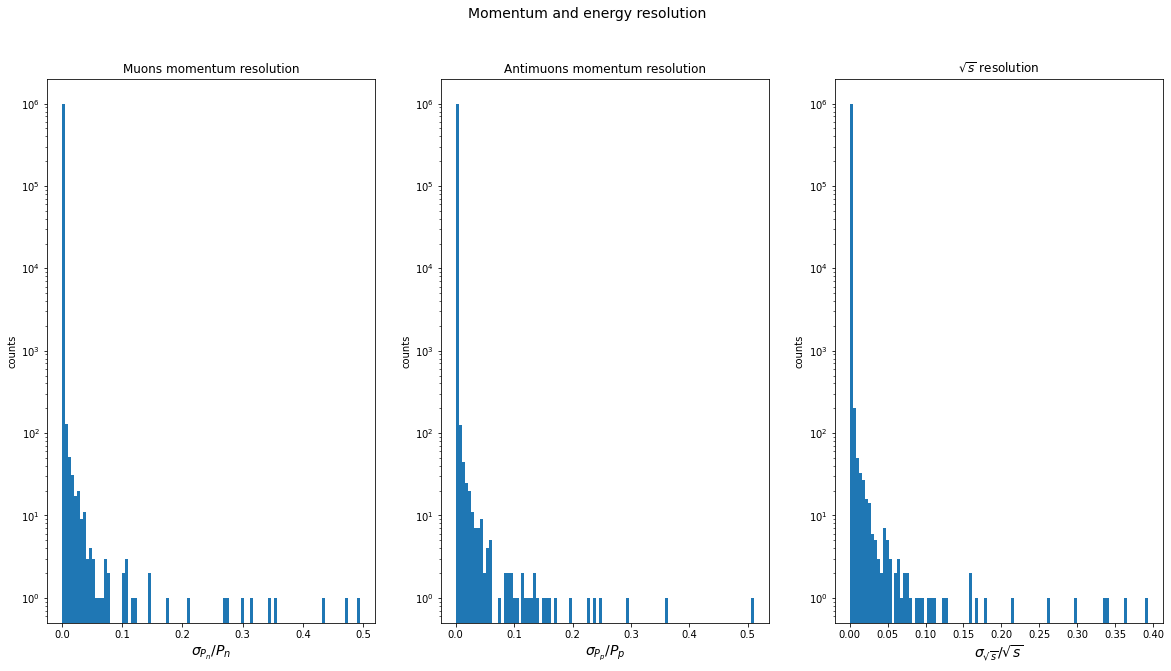

Muons momentum resolution mean:  0.0003442740357927964
Antimuons momentum resolution mean:  0.00034345899375287707
Energy resolution mean:  0.00035916584610722735


In [ ]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
fig.suptitle('Momentum and energy resolution',fontsize=14)

ax1.set_title('Muons momentum resolution')
ax1.hist(resn, bins=100)
ax1.set_xlabel(r"$\sigma_{P_n}/P_n$", fontsize=14)
ax1.set_ylabel("counts")
ax1.set_yscale('log')

ax2.set_title('Antimuons momentum resolution')
ax2.hist(resp, bins=100)
ax2.set_xlabel(r"$\sigma_{P_p}/P_p$", fontsize=14)
ax2.set_ylabel("counts")
ax2.set_yscale('log')

ax3.set_title(r'$\sqrt{s}$ resolution')
ax3.hist(resS, bins=100)
ax3.set_xlabel(r"$\sigma_{\sqrt{s}}/\sqrt{s}$", fontsize=14)
ax3.set_ylabel("counts")
ax3.set_yscale('log')

plt.show()

print('Muons momentum resolution mean: ',np.array(resn).mean())
print('Antimuons momentum resolution mean: ',np.array(resp).mean())
print('Energy resolution mean: ',np.array(resS).mean())

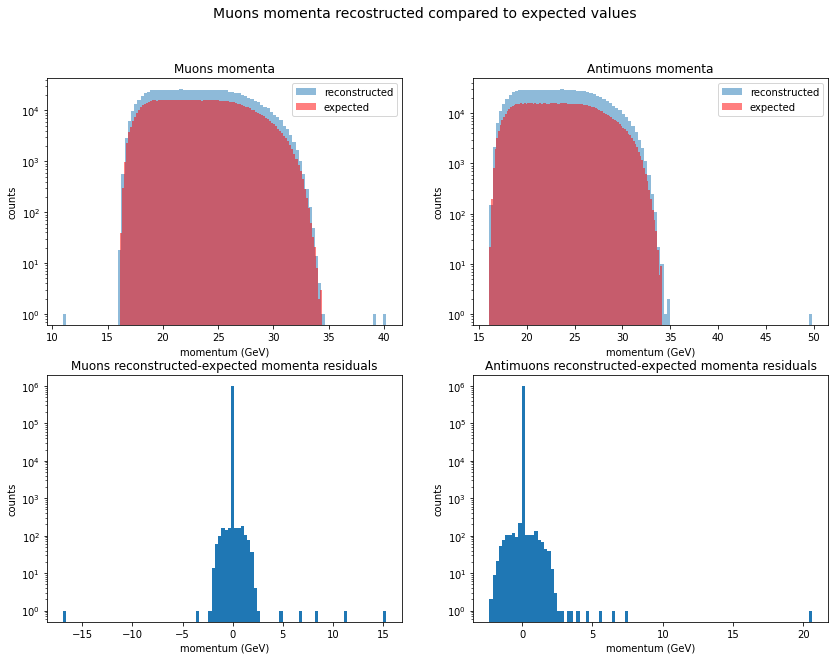

In [ ]:
#Log scales, to mark deviation from fit of noise
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Muons momenta recostructed compared to expected values',fontsize=14)

ax1.set_title('Muons momenta')
ax1.hist(Pn, alpha=0.5, bins=100,  label='reconstructed')
ax1.hist(Pn_theo, color='red', alpha=0.5, bins=100, label='expected')
ax1.set_xlabel("momentum (GeV)")
ax1.set_ylabel("counts")
ax1.set_yscale('log')
ax1.legend()

ax2.set_title('Antimuons momenta')
ax2.hist(Pp, alpha=0.5, bins=100, label='reconstructed')
ax2.hist(Pp_theo,color='red', alpha=0.5, bins=100, label='expected')
ax2.set_xlabel("momentum (GeV)")
ax2.set_ylabel("counts")
ax2.set_yscale('log')
ax2.legend()

ax3.set_title('Muons reconstructed-expected momenta residuals')
ax3.hist(np.array(Pn)-np.array(Pn_theo), bins=100)
ax3.set_xlabel("momentum (GeV)")
ax3.set_ylabel("counts")
ax3.set_yscale('log')

ax4.set_title('Antimuons reconstructed-expected momenta residuals')
ax4.hist(np.array(Pp)-np.array(Pp_theo), bins=100)
ax4.set_xlabel("momentum (GeV)")
ax4.set_ylabel("counts")
ax4.set_yscale('log')

plt.show()

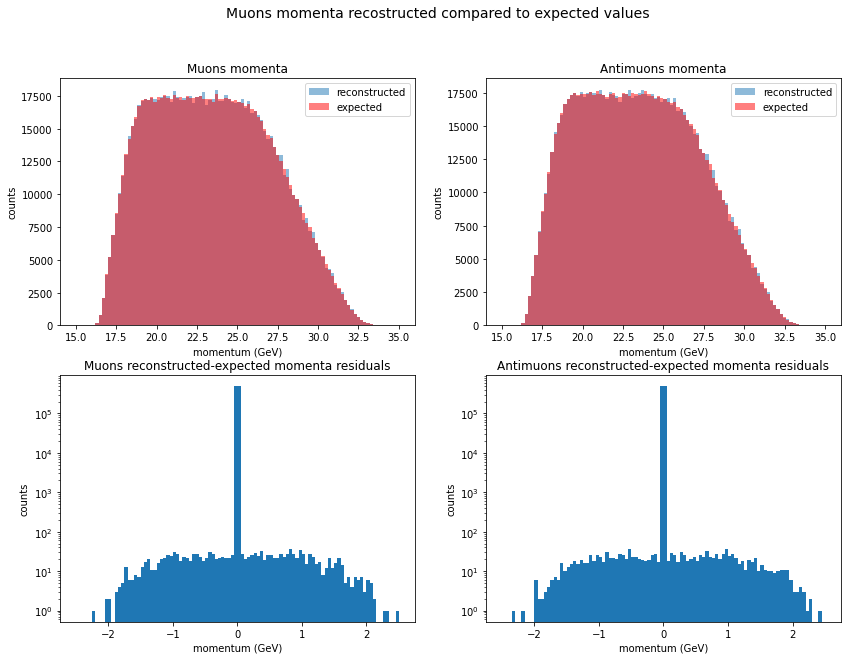

In [ ]:
#focus on the interesting phase space parameter region (exclude the few outliers)
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Muons momenta recostructed compared to expected values',fontsize=14)

ax1.set_title('Muons momenta')
ax1.hist(Pn, alpha=0.5, bins=100, range=[15,35], label='reconstructed')
ax1.hist(Pn_theo, color='red', alpha=0.5, bins=100, range=[15,35], label='expected')
ax1.set_xlabel("momentum (GeV)")
ax1.set_ylabel("counts")

ax1.legend()

ax2.set_title('Antimuons momenta')
ax2.hist(Pp, alpha=0.5, bins=100,range=[15,35], label='reconstructed')
ax2.hist(Pp_theo,color='red', alpha=0.5, bins=100,range=[15,35], label='expected')
ax2.set_xlabel("momentum (GeV)")
ax2.set_ylabel("counts")
ax2.legend()

ax3.set_title('Muons reconstructed-expected momenta residuals')
ax3.hist(np.array(Pn)-np.array(Pn_theo), bins=100,range=[-2.5,2.5])
ax3.set_xlabel("momentum (GeV)")
ax3.set_ylabel("counts")
ax3.set_yscale('log')

ax4.set_title('Antimuons reconstructed-expected momenta residuals')
ax4.hist(np.array(Pp)-np.array(Pp_theo), bins=100,range=[-2.5,2.5])
ax4.set_xlabel("momentum (GeV)")
ax4.set_ylabel("counts")
ax4.set_yscale('log')

plt.show()

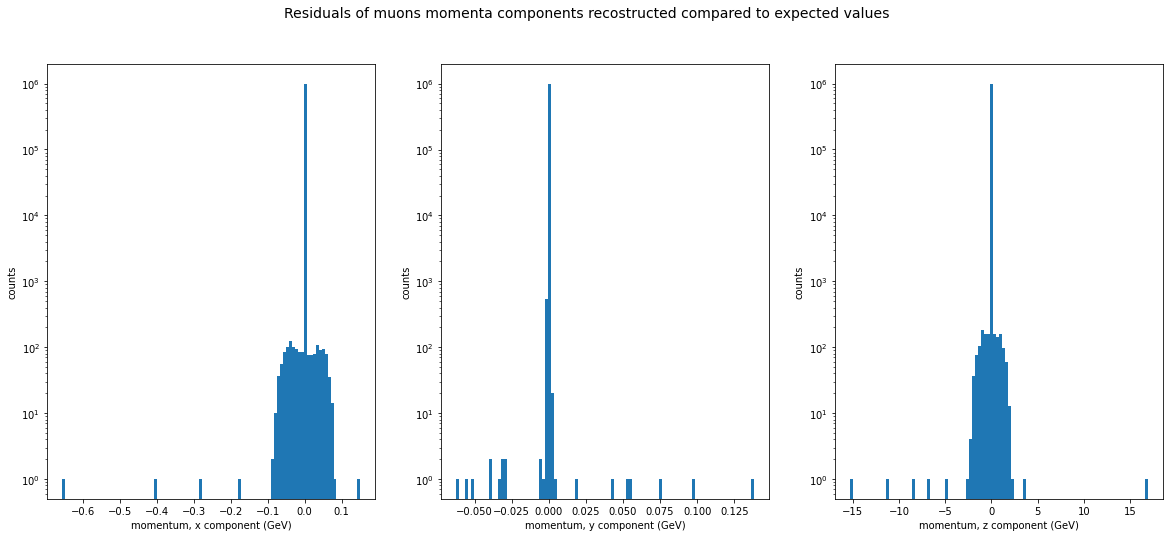

In [ ]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,8))
fig.suptitle('Residuals of muons momenta components recostructed compared to expected values',fontsize=14)

ax1.hist(Pxn_diff, bins=100)
ax1.set_xlabel("momentum, x component (GeV)")
ax1.set_ylabel("counts")
ax1.set_yscale('log')

ax2.hist(Pyn_diff, bins=100)
ax2.set_xlabel("momentum, y component (GeV)")
ax2.set_ylabel("counts")
ax2.set_yscale('log')

ax3.hist(Pzn_diff, bins=100)
ax3.set_xlabel("momentum, z component (GeV)")
ax3.set_ylabel("counts")
ax3.set_yscale('log')

plt.show()

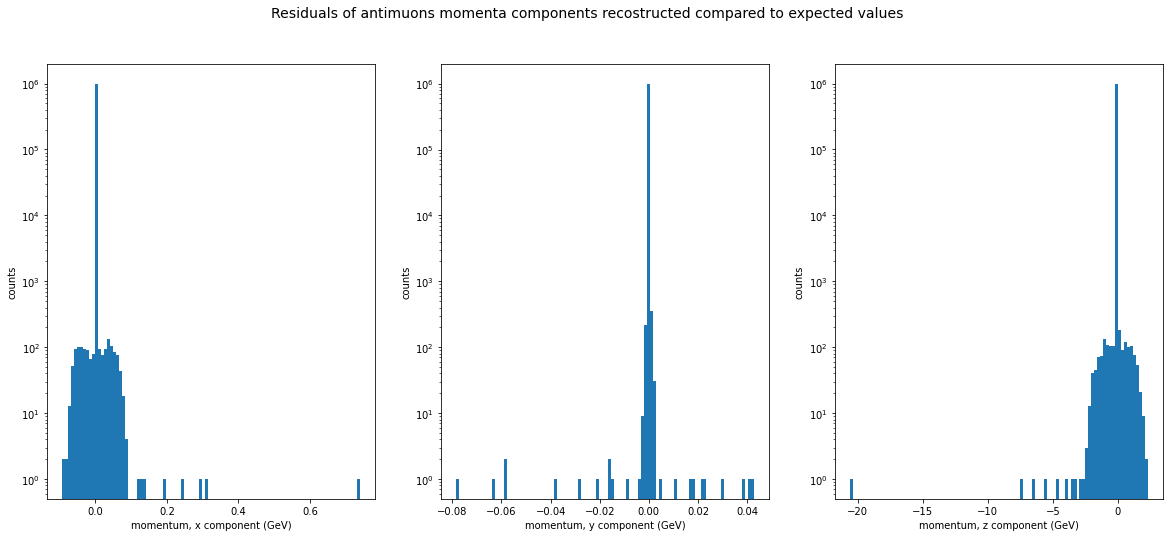

In [ ]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,8))
fig.suptitle('Residuals of antimuons momenta components recostructed compared to expected values',fontsize=14)

ax1.hist(Pxp_diff, bins=100)
ax1.set_xlabel("momentum, x component (GeV)")
ax1.set_ylabel("counts")
ax1.set_yscale('log')

ax2.hist(Pyp_diff, bins=100)
ax2.set_xlabel("momentum, y component (GeV)")
ax2.set_ylabel("counts")
ax2.set_yscale('log')

ax3.hist(Pzp_diff, bins=100)
ax3.set_xlabel("momentum, z component (GeV)")
ax3.set_ylabel("counts")
ax3.set_yscale('log')

plt.show()

# Conclusions

We succesfully built the set-up and algorithm needed to reconstruct the momenta of muons with good resolution (about 0.00035) and very small failure rate (around 2‰). It is also apparent that reconstruction of $p_y$ component, thanks to the linearity of the trajectory along $y$ axis, yelds the best results in term of residuals between expected and reconstructed values (1 order of magnitude less) if compared to the others components